# SIT 220 - Task 1.8HD: Data Cleansing and Text Analysis Challenge

### Hoang Son Pham - Student ID: 223240555

## Introduction

This project focuses on analyzing discussions about `ChatGPT` on the **Data Science Stack Exchange** platform. The analysis involves data cleansing, exploratory data analysis, sentiment analysis, and advanced insights extraction. By leveraging natural language processing (NLP) techniques, machine learning models, and geospatial visualization, the study aims to uncover patterns in user discussions, sentiment trends, and thematic categories. The project also emphasizes ethical considerations, ensuring user privacy and minimizing bias in the analysis. Through this comprehensive approach, the study provides valuable insights into how the data science community perceives and interacts with ChatGPT technology.



## 0. Import necessary libraries

In [ ]:
# General Packages for Data Manipulation and File Handling
import os
import re
import csv
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import requests
import json

# Text Processing and NLP Packages
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
from transformers import pipeline
from scipy.special import softmax
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('vader_lexicon')
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
# Machine Learning and Model Evaluation
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
# Miscellaneous
from collections import Counter

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/macbook/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 1. Create helper functions

In [2]:
#Functions to convert xml file to csv file
def xml_to_csv(xml_file, csv_file):
    context = ET.iterparse(xml_file, events=("start", "end"))
    context = iter(context)
    _, root = next(context)
    rows = []
    for event, elem in context:
        if event == "end" and elem.tag == "row":
            rows.append(elem.attrib)
            elem.clear()
            root.clear()
    df = pd.DataFrame(rows)
    df.to_csv(csv_file, index=False)

In [3]:
# Function to clean text by removing HTML tags and special characters
def clean_text(text):
    """Remove HTML tags and special characters from text using regex."""
    if pd.isna(text):
        return ''
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) # Remove URLs
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Keep only letters, numbers and spaces
    return text.lower().strip()  # Convert to lowercase and remove leading/trailing spaces



In [4]:
#Functions to find texts containing the keywords
def contains_topic(text, keywords):
    """
    Check if the text contains any of the specified keywords (case-insensitive).
    
    Parameters:
        text (str): The normalized text.
        keywords (list): List of keywords.
        
    Returns:
        bool: True if any keyword is found, False otherwise.
    """
    text_lower = text.lower()
    return any(keyword in text_lower for keyword in keywords)


In [5]:
#Functions to remove stop words and lemmatize the text
def lemmatize_text(text):
    """
    Pipeline to normalize text by cleaning and optionally removing stopwords.
    
    Parameters:
        text (str): Raw text.
    
    Returns:
        str: Normalized text.
    """
    # Tokenize
    tokens = word_tokenize(text)
        
    # Remove stopwords and lemmatize
    processed_tokens = [
        WordNetLemmatizer().lemmatize(token) 
        for token in tokens 
        if token not in set(stopwords.words('english')) and len(token) > 2
    ]
        
    return ' '.join(processed_tokens)

In [6]:
#Functions to count the number of words in a text block
def count_words(text):
    """Count the number of words in cleaned text."""
    if not text:
        return 0
    return len(re.findall(r'\b\w+\b', text))  # Match word boundaries

In [7]:
#Function to check if the text has code
def count_code_blocks(text):
    """Count the number of <code> blocks in text using regex."""
    if pd.isna(text):
        return 0
    return len(re.findall(r'<code>.*?</code>', text, flags=re.DOTALL))

In [8]:
#Initialize the sentiment analysis pipeline
sentiment_analyzer = SentimentIntensityAnalyzer()

#Function to calculate the polarity score of a text
def get_sentiment_score(text):
    """
    Calculate and return the sentiment score for the given text.
    The score represents the confidence (probability) for the predicted label.
    
    Parameters:
        text (str): The input text to analyze.
        
    Returns:
        float: The sentiment score.
    """
    result = sentiment_analyzer.polarity_scores(text)
    return result["compound"]

In [9]:
#Function to classify the sentiment scores
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
    

## 2. Load and explore the datasets

In [10]:

# Set paths for the XML files and the new CSV output directory
xml_dir = "datascience.stackexchange.com"
csv_output_dir = "csv_output"

# Create the output directory if it doesn't exist
if not os.path.exists(csv_output_dir):
    os.makedirs(csv_output_dir)

# Loop through each file in the XML directory
for file in os.listdir(xml_dir):
    if file.lower().endswith(".xml"):
        xml_file_path = os.path.join(xml_dir, file)
        csv_file_name = f"{os.path.splitext(file)[0]}.csv"
        csv_file_path = os.path.join(csv_output_dir, csv_file_name)
        xml_to_csv(xml_file_path, csv_file_path)

In [11]:
#Read the datasets
posts_df = pd.read_csv(os.path.join(csv_output_dir, 'Posts.csv'))
users_df = pd.read_csv(os.path.join(csv_output_dir, 'Users.csv'))
tags_df = pd.read_csv(os.path.join(csv_output_dir, 'Tags.csv'))
comments_df = pd.read_csv(os.path.join(csv_output_dir, 'Comments.csv'))
votes_df = pd.read_csv(os.path.join(csv_output_dir, 'Votes.csv'))

### Quick look at posts dataset

In [12]:

posts_df.info()
posts_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78926 entries, 0 to 78925
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     78926 non-null  int64  
 1   PostTypeId             78926 non-null  int64  
 2   CreationDate           78926 non-null  object 
 3   Score                  78926 non-null  int64  
 4   ViewCount              36775 non-null  float64
 5   Body                   78758 non-null  object 
 6   OwnerUserId            78448 non-null  float64
 7   LastActivityDate       78926 non-null  object 
 8   Title                  36775 non-null  object 
 9   Tags                   36775 non-null  object 
 10  AnswerCount            36775 non-null  float64
 11  CommentCount           78926 non-null  int64  
 12  ClosedDate             2246 non-null   object 
 13  ContentLicense         78926 non-null  object 
 14  AcceptedAnswerId       12190 non-null  float64
 15  La

Id  PostTypeId             CreationDate  Score  ViewCount  \
0   5           1  2014-05-13T23:58:30.457      9      968.0   
1   7           1  2014-05-14T00:11:06.457      4      510.0   
2   9           2  2014-05-14T00:36:31.077      5        NaN   
3  10           2  2014-05-14T00:53:43.273     13        NaN   
4  14           1  2014-05-14T01:25:59.677     26     1931.0   

                                                Body  OwnerUserId  \
0  <p>I've always been interested in machine lear...          5.0   
1  <p>As a researcher and instructor, I'm looking...         36.0   
2  <p>Not sure if this fits the scope of this SE,...         51.0   
3  <p>One book that's freely available is "The El...         22.0   
4  <p>I am sure data science as will be discussed...         66.0   

          LastActivityDate                                              Title  \
0  2014-05-14T00:36:31.077  How can I do simple machine learning without h...   
1  2014-05-16T13:45:00.237  What open-source books (or other materials) pr...   
2  2014-05-14T00:36:31.077                                                NaN   
3  2014-05-14T00:53:43.273                                                NaN   
4  2020-08-16T13:01:33.543           Is Data Science the Same as Data Mining?   

                        Tags  ...               ClosedDate  ContentLicense  \
0         |machine-learning|  ...  2014-05-14T14:40:25.950    CC BY-SA 3.0   
1    |education|open-source|  ...  2014-05-14T08:40:54.950    CC BY-SA 3.0   
2                        NaN  ...                      NaN    CC BY-SA 3.0   
3                        NaN  ...                      NaN    CC BY-SA 3.0   
4  |data-mining|definitions|  ...                      NaN    CC BY-SA 3.0   

  AcceptedAnswerId LastEditorUserId             LastEditDate  ParentId  \
0              NaN              NaN                      NaN       NaN   
1             10.0             97.0  2014-05-16T13:45:00.237       NaN   
2              NaN              NaN                      NaN       5.0   
3              NaN              NaN                      NaN       7.0   
4             29.0            322.0  2014-06-17T16:17:20.473       NaN   

  OwnerDisplayName  CommunityOwnedDate LastEditorDisplayName FavoriteCount  
0              NaN                 NaN                   NaN           NaN  
1              NaN                 NaN                   NaN           NaN  
2              NaN                 NaN                   NaN           NaN  
3              NaN                 NaN                   NaN           NaN  
4              NaN                 NaN                   NaN           NaN  

[5 rows x 22 columns]

### Quick look at users dataset

In [13]:
users_df.info()
users_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137433 entries, 0 to 137432
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Id              137433 non-null  int64  
 1   Reputation      137433 non-null  int64  
 2   CreationDate    137433 non-null  object 
 3   DisplayName     137423 non-null  object 
 4   LastAccessDate  137433 non-null  object 
 5   WebsiteUrl      19843 non-null   object 
 6   Location        53558 non-null   object 
 7   AboutMe         37426 non-null   object 
 8   Views           137433 non-null  int64  
 9   UpVotes         137433 non-null  int64  
 10  DownVotes       137433 non-null  int64  
 11  AccountId       137426 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 12.6+ MB


Id  Reputation             CreationDate   DisplayName  \
0  -1           1  2014-05-13T21:29:22.820     Community   
1   1         101  2014-05-13T22:58:54.810     Adam Lear   
2   2         101  2014-05-13T22:59:19.787  Geoff Dalgas   
3   3         101  2014-05-13T23:15:34.483    hichris123   
4   4         101  2014-05-13T23:16:09.937   Ben Collins   

            LastAccessDate                      WebsiteUrl  \
0  2014-05-13T21:29:22.820  http://meta.stackexchange.com/   
1  2024-03-11T21:29:14.793                             NaN   
2  2019-09-03T19:10:22.217        http://stackoverflow.com   
3  2020-12-16T17:41:49.610                             NaN   
4  2014-08-04T15:25:54.810      http://benjamincollins.com   

             Location                                            AboutMe  \
0  on the server farm  <p>Hi, I'm not really a person.</p>\n\n<p>I'm ...   
1        New York, NY  \n<p>Developer at Stack Overflow focusing on p...   
2       Corvallis, OR  <p>Dev #2 who helped create Stack Overflow cur...   
3                 NaN  <p>I'm a student interested in technology.</p>...   
4   Republic of Texas  <p>I work with <a href="https://olo.com" rel="...   

   Views  UpVotes  DownVotes  AccountId  
0    546        0          0       -1.0  
1    725        0          0    37099.0  
2     12        0          0        2.0  
3      9        1          3  3046327.0  
4      9        0          0     2365.0

### Quick look at tags dataset

In [14]:
tags_df.info()
tags_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             702 non-null    int64  
 1   TagName        702 non-null    object 
 2   Count          702 non-null    int64  
 3   ExcerptPostId  310 non-null    float64
 4   WikiPostId     310 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 27.6+ KB


Id           TagName  Count  ExcerptPostId  WikiPostId
0   1       definitions     39          105.0       104.0
1   2  machine-learning  11403         4909.0      4908.0
2   3           bigdata    456           66.0        65.0
3   5       data-mining   1181           80.0        79.0
4   6         databases    100         8960.0      8959.0

### Quick look at comments dataset

In [15]:
comments_df.info()
comments_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82370 entries, 0 to 82369
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               82370 non-null  int64  
 1   PostId           82370 non-null  int64  
 2   Score            82370 non-null  int64  
 3   Text             82370 non-null  object 
 4   CreationDate     82370 non-null  object 
 5   UserId           81774 non-null  float64
 6   UserDisplayName  596 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 4.4+ MB


Id  PostId  Score                                               Text  \
0   5       5      9  this is a super theoretical AI question. An in...   
1   6       7      4  List questions are usually not suited for Stac...   
2   9       7      3  This question appears to be off-topic because ...   
3  14       7      0  Fair enough regarding what constitutes a "vali...   
4  80       7      1  @statsRus: Try posting a question like that to...   

              CreationDate  UserId UserDisplayName  
0  2014-05-14T00:23:15.437    34.0             NaN  
1  2014-05-14T00:38:19.510    51.0             NaN  
2  2014-05-14T01:16:12.623    66.0             NaN  
3  2014-05-14T02:35:50.090    36.0             NaN  
4  2014-05-15T21:08:13.933   158.0             NaN

## 3. Data Cleaning 

In this part, we will focus on cleaning the text data by removing the special characters, tags, HTML syntax and trailing spaces. These actions are executed using the helper functions that we created earlier. 

### Clean Posts dataset

In [16]:
posts_df["CreationDate"] = pd.to_datetime(posts_df["CreationDate"] )

In [17]:
drop_cols = ["PostTypeId", "LastActivityDate", "ClosedDate", "ContentLicense",
             "AcceptedAnswerId","LastEditorUserId","LastEditDate","ParentId", "OwnerDisplayName", "CommunityOwnedDate",
             "LastEditorDisplayName", "FavoriteCount"]
posts_df.drop(columns = drop_cols, inplace=True)
posts_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78926 entries, 0 to 78925
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Id            78926 non-null  int64         
 1   CreationDate  78926 non-null  datetime64[ns]
 2   Score         78926 non-null  int64         
 3   ViewCount     36775 non-null  float64       
 4   Body          78758 non-null  object        
 5   OwnerUserId   78448 non-null  float64       
 6   Title         36775 non-null  object        
 7   Tags          36775 non-null  object        
 8   AnswerCount   36775 non-null  float64       
 9   CommentCount  78926 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 6.0+ MB


In [18]:
posts_df['CleanBody'] = posts_df['Body'].apply(clean_text)
posts_df['CleanTitle'] = posts_df['Title'].apply(clean_text)

**As the Data Science stack exchange covers many topics, we will only focus on discussions about ChatGPT to investigate the people's opinions and concerns regarding this particular topic. Now we will search for posts containing the keywords: GPT, ChatGPT and OpenAI using regex and export them to a new dataframe**

### Filtering posts concerning ChatGPT

In [19]:
#Keywords about Chatgpt
topic_keywords = ['gpt', 'chatgpt', 'openai']

#Search among the title and body texts to find the keywords and extract the related posts
gpt_post_df = posts_df[
    posts_df['CleanBody'].apply(lambda x:contains_topic(x, topic_keywords)) |
    posts_df['CleanTitle'].apply(lambda x:contains_topic(x, topic_keywords))
]
gpt_post_df.reset_index(drop=True, inplace=True)
print("Total posts related to GPT/ChatGPT:", len(gpt_post_df))
gpt_post_df.head()

Total posts related to GPT/ChatGPT: 491


Id            CreationDate  Score  ViewCount  \
0   5830 2015-05-19 02:09:13.700      2      518.0   
1  13820 2016-09-02 11:15:19.617      1     9808.0   
2  16067 2017-01-04 14:17:56.523      8        NaN   
3  16072 2017-01-04 17:36:53.577      4        NaN   
4  16980 2017-02-14 23:50:35.533      1        NaN   

                                                Body  OwnerUserId  \
0  <p>I was informed of 5 java NLP libraries.</p>...          NaN   
1  <p>I installed orange version 3 yesterday. I d...      24007.0   
2  <p>There are multiple ways to approach solving...        836.0   
3  <p>What you are looking for is called <em>Rein...       8820.0   
4  <p>You could use the same reward function that...      18626.0   

                                               Title           Tags  \
0  How do I best parse ECOG scores in cancer clin...     |nlp|java|   
1              Target variable problem :- Classifier  |data|orange|   
2                                                NaN            NaN   
3                                                NaN            NaN   
4                                                NaN            NaN   

   AnswerCount  CommentCount  \
0          0.0             0   
1          1.0             0   
2          NaN             0   
3          NaN             0   
4          NaN             8   

                                           CleanBody  \
0  i was informed of 5 java nlp libraries\n\n\nap...   
1  i installed orange version 3 yesterday i defin...   
2  there are multiple ways to approach solving ga...   
3  what you are looking for is called reinforceme...   
4  you could use the same reward function that op...   

                                          CleanTitle  
0  how do i best parse ecog scores in cancer clin...  
1                target variable problem  classifier  
2                                                     
3                                                     
4

In [20]:
gpt_post_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Id            491 non-null    int64         
 1   CreationDate  491 non-null    datetime64[ns]
 2   Score         491 non-null    int64         
 3   ViewCount     282 non-null    float64       
 4   Body          491 non-null    object        
 5   OwnerUserId   488 non-null    float64       
 6   Title         282 non-null    object        
 7   Tags          282 non-null    object        
 8   AnswerCount   282 non-null    float64       
 9   CommentCount  491 non-null    int64         
 10  CleanBody     491 non-null    object        
 11  CleanTitle    491 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 46.2+ KB


In [21]:
gpt_post_df["Body"] = gpt_post_df["Body"].fillna('')
gpt_post_df["Title"] = gpt_post_df["Title"].fillna('')

We have collected 390 posts related to ChatGPT. This is not a large number of posts considering the total the number of nearly 80k posts in the dataset. However, we can still reveal a lot of intriguing insights from this dataframe.

### Clean Comments dataset

Comments dataset is another source that requires deep investigation as we could reveal how people react and interact with certain type of contents

In [22]:
comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82370 entries, 0 to 82369
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               82370 non-null  int64  
 1   PostId           82370 non-null  int64  
 2   Score            82370 non-null  int64  
 3   Text             82370 non-null  object 
 4   CreationDate     82370 non-null  object 
 5   UserId           81774 non-null  float64
 6   UserDisplayName  596 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 4.4+ MB


We also clean the comment text to prepare for analysis

In [23]:
comments_df["CleanText"] = comments_df["Text"].apply(clean_text)


We group the comments data by post ID and then join them together as one post can attract a lot of comments/interaction. This will make it easier for us to merge the datasets later on and analyze the relationship between the post and its specific comments. 

In [24]:
comments_grouped = comments_df.groupby("PostId")["CleanText"].apply(' '.join).reset_index()
comments_grouped.columns = ["PostId", 'CleanComment']

In [25]:
comments_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31894 entries, 0 to 31893
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PostId        31894 non-null  int64 
 1   CleanComment  31894 non-null  object
dtypes: int64(1), object(1)
memory usage: 498.5+ KB


## 4. Exploratory Data Analysis

**In this part, we will perform some exploration steps on the posts to reveal some fundamental statistics about the dataset.**

In [26]:
print(gpt_post_df.info())
print(gpt_post_df.iloc[:,1:].describe(include='number'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Id            491 non-null    int64         
 1   CreationDate  491 non-null    datetime64[ns]
 2   Score         491 non-null    int64         
 3   ViewCount     282 non-null    float64       
 4   Body          491 non-null    object        
 5   OwnerUserId   488 non-null    float64       
 6   Title         491 non-null    object        
 7   Tags          282 non-null    object        
 8   AnswerCount   282 non-null    float64       
 9   CommentCount  491 non-null    int64         
 10  CleanBody     491 non-null    object        
 11  CleanTitle    491 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 46.2+ KB
None
            Score     ViewCount    OwnerUserId  AnswerCount  CommentCount
count  491.000000    282.000000   

### Distribution of posts over years

We draw a bar plot to identify the numbers of posts about ChatGPT over the years

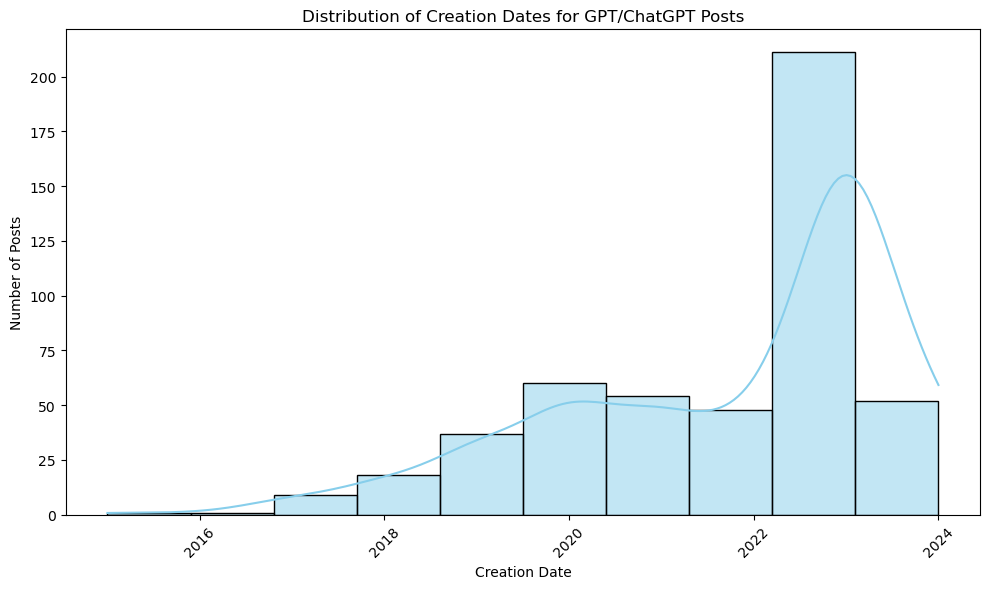

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(gpt_post_df['CreationDate'].dt.year,bins=10, color='skyblue', kde=True)
plt.title("Distribution of Creation Dates for GPT/ChatGPT Posts")
plt.xlabel("Creation Date")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Looking at the bar chart, we can see that there are rarely any post about ChatGPT from 2015 to 2018. However the gradual rise was observed in the following year 2018 and 2019. The number of posts continued to surge and skyrocketed in 2023 with more than 180 posts. This paramount increase is explicable as 2023 saw the introduction of GPT-3 which shook the world significantly. The total number decreased sharply in 2024 which requires futher analysis.

### Distribution of total number of words in each post

We count the total number of words used in body text and title and create a histogram to plot the distribution

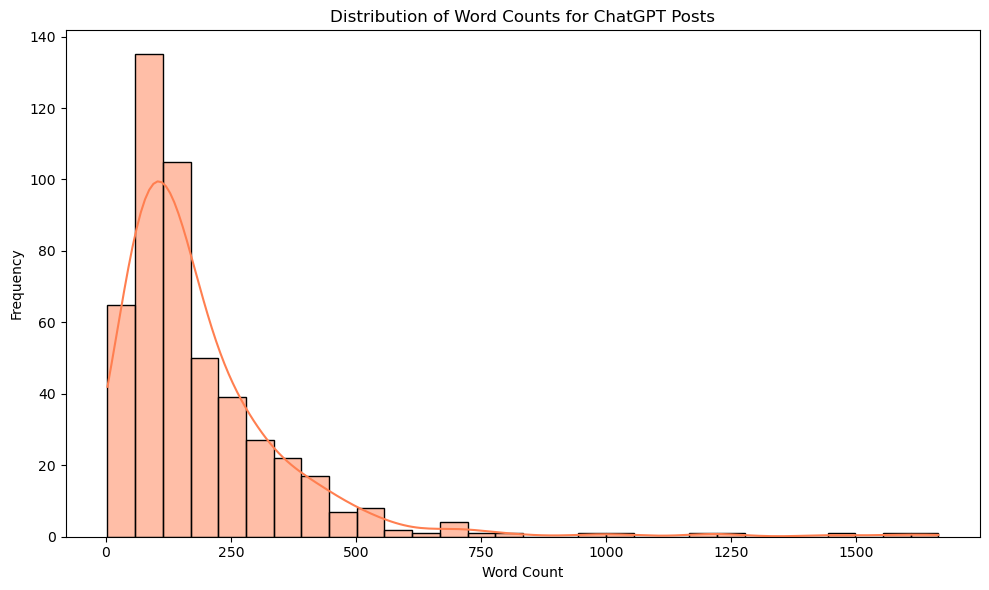

In [28]:
#Count the total number of word using the count_words function
gpt_post_df['WordCount'] = gpt_post_df['CleanBody'].apply(count_words)

plt.figure(figsize=(10, 6))
sns.histplot(gpt_post_df['WordCount'], bins=30, kde=True, color='coral')
plt.title("Distribution of Word Counts for ChatGPT Posts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Examining the distribution of word counts for GPT/ChatGPT posts reveals a clear tendency towards brevity. The most frequent post lengths cluster within the lower word count ranges, exhibiting a significant peak between approximately 50 and 100 words, with a substantial number also falling within the 100 to 200-word range. Beyond this point, the frequency of posts diminishes rapidly. The long tail extending towards higher word counts indicates that while the majority of discussions are concise, a small proportion of posts involve more extensive content. 

### Distribution of posts with code and without code

Count the number of code blocks used in each post and plot the distribution

/var/folders/dn/pf9_4vwj35g7wrw5hn5rlfn80000gn/T/ipykernel_21598/103492404.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='code_presence', x='count', data=code_counts, palette='pastel')


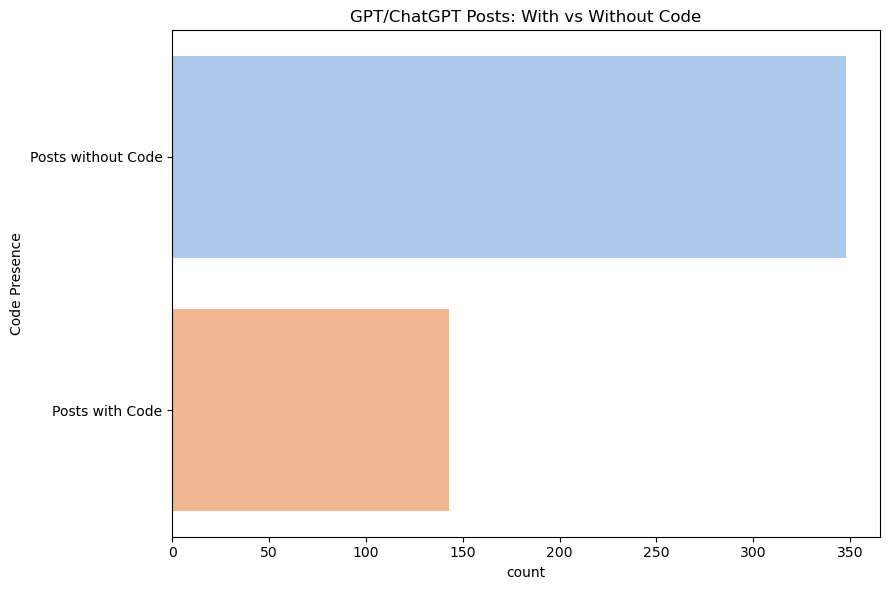

In [29]:
# Create a new column that counts the number of code blocks in each post using the original 'Body'
gpt_post_df['CodeCount'] = gpt_post_df['Body'].apply(count_code_blocks)

# Create a binary flag: True if the post has one or more code blocks, False otherwise
gpt_post_df['has_code'] = gpt_post_df['CodeCount'] > 0

# Count posts with and without code
code_counts = gpt_post_df['has_code'].value_counts().reset_index()
code_counts.columns = ['has_code', 'count']

# Relabel the flag for plotting purposes
code_counts['code_presence'] = code_counts['has_code'].map({True: 'Posts with Code', False: 'Posts without Code'})

# Plot the counts as a bar chart
plt.figure(figsize=(9, 6))
sns.barplot(y='code_presence', x='count', data=code_counts, palette='pastel')
plt.title("GPT/ChatGPT Posts: With vs Without Code")
plt.ylabel("Code Presence")
plt.tight_layout()
plt.show()

The number of posts that contain code blocks considerably outnumbers the plain posts. This revelation shows people's tendency of discussing technical implementation rather than other aspects of AI or ChatGPT in specific. This also presents the nature of forums in stack exchange which attract a lot or engineers and analysts. 

### Distribution of tags

We will explore what tags are most attached to users' posts

In [30]:
# Function to extract tags from the Tag field
def extract_tags(tag_string):
    if pd.isna(tag_string):
        return []
    # Remove angle brackets and split by '><'
    tags = re.sub(r'[|]', ' ', tag_string).split()
    return [tag.strip() for tag in tags if tag.strip()]

# Extract tags from gpt_post_df
gpt_post_df['TagsList'] = gpt_post_df['Tags'].apply(extract_tags)

# Create a flattened list of all tags
all_tags = []
for tags in gpt_post_df['TagsList']:
    all_tags.extend(tags)

# Count tag frequencies
tag_counts = pd.Series(all_tags).value_counts()
top_tags = tag_counts.head(20)  # Top 20 tags

/var/folders/dn/pf9_4vwj35g7wrw5hn5rlfn80000gn/T/ipykernel_21598/1317809773.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


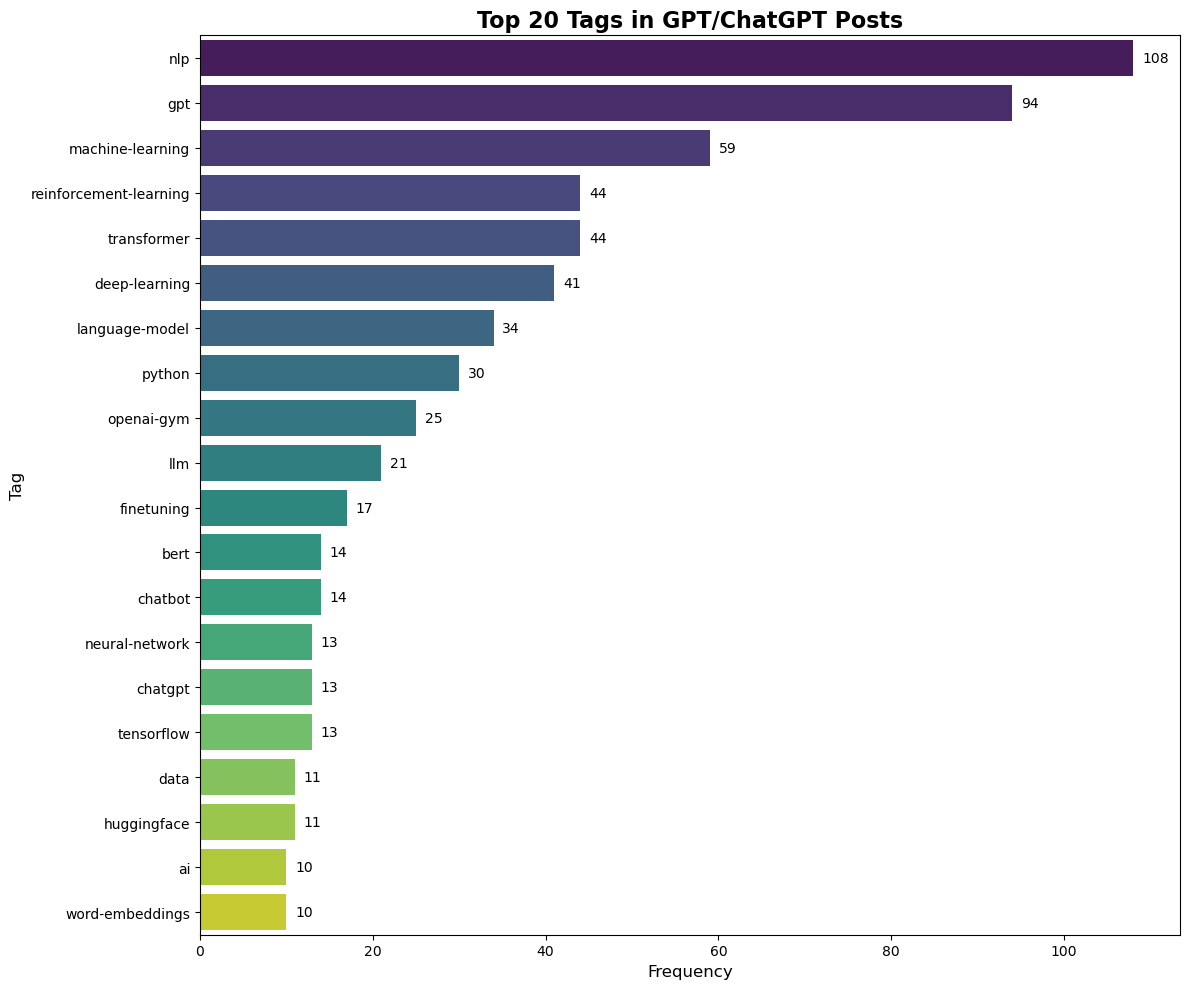

In [31]:
# Create a horizontal bar chart with color gradient based on frequency
plt.figure(figsize=(12, 10))
ax = sns.barplot(
    y=top_tags.index,
    x=top_tags.values,
    palette=sns.color_palette("viridis", len(top_tags))
)

# Add count annotations to bars
for i, v in enumerate(top_tags.values):
    ax.text(v + 1, i, f"{v}", va='center')

# Set titles and labels
plt.title('Top 20 Tags in GPT/ChatGPT Posts', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Tag', fontsize=12)
plt.tight_layout()
plt.savefig('top_tags_gpt_posts.png', dpi=300, bbox_inches='tight')
plt.show()

Delving deeper into the chart, the prominence of "nlp" (Natural Language Processing) with 108 occurrences underscores its fundamental role in the context of GPT and ChatGPT, which are advanced NLP models. The tag "gpt" itself being the second most frequent (94) indicates a significant focus directly on the model architecture or its applications. Following these, we see "machine-learning" (59) and "reinforcement-learning" (44), highlighting the underlying methodologies used to train these powerful language models.

Interestingly, "transformer" (44) appears with the same frequency as "reinforcement-learning," pointing to the crucial transformer architecture that underpins GPT models. The presence of "deep-learning" (41) further reinforces the AI paradigm these models belong to. More application-oriented tags like "language-model" (34), "python" (30), and "openai-gym" (25) suggest discussions around the practical usage, coding environment, and related tools.

The drop in frequency after the top few tags is noticeable, indicating a long tail of more specific or less frequently discussed topics. The appearance of tags like "llm" (21), "finetuning" (17), "bert" (14), and "chatgpt" (13) shows engagement with specific model variants, training techniques, and the chatbot application itself. The presence of libraries like "tensorflow" (13) and "huggingface" (11) suggests discussions within the developer and practitioner communities. Finally, the lower frequency of more general AI terms like "ai" (10) and "word-embeddings" (10) might imply that discussions tend to be more focused on the specific models and techniques rather than broader AI concepts.

### Top tags over the years

We extract the top 5 common tags and plot their use over different years

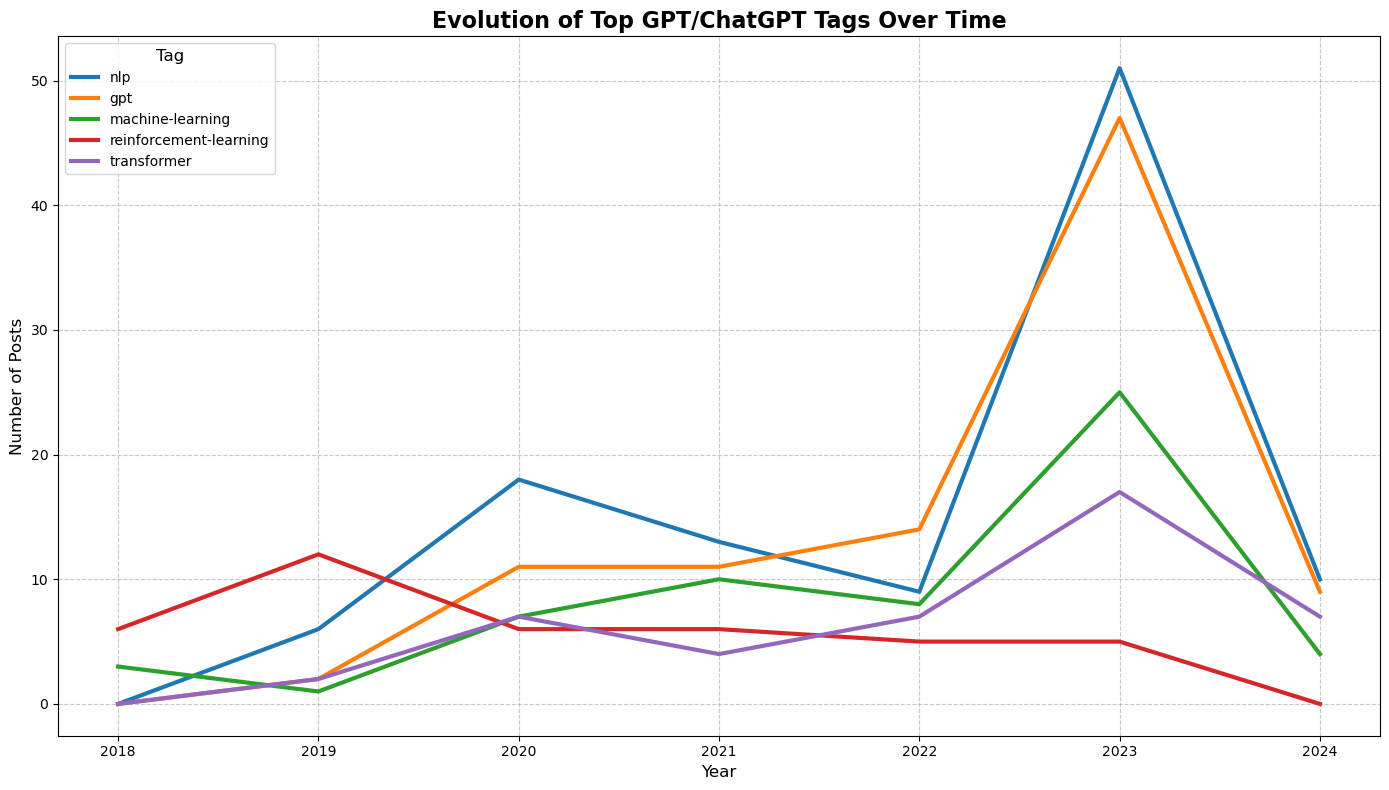

In [32]:
# Analyze how tags have evolved over time
gpt_post_df['Year'] = gpt_post_df['CreationDate'].dt.year

# Get top 5 tags for time series visualization
top5_tags = tag_counts.head(5).index.tolist()

# Create a dataframe for time series
tag_time_data = []
for year in range(2018, 2025):  # Adjust range based on your data
    year_posts = gpt_post_df[gpt_post_df['Year'] == year]
    year_tags = []
    for tags in year_posts['TagsList']:
        year_tags.extend(tags)
    
    if year_tags:  # Avoid empty years
        tag_counts_year = pd.Series(year_tags).value_counts()
        for tag in top5_tags:
            count = tag_counts_year.get(tag, 0)
            tag_time_data.append({'Year': year, 'Tag': tag, 'Count': count})

# Convert to DataFrame
tag_time_df = pd.DataFrame(tag_time_data)

# Create the time series plot
plt.figure(figsize=(14, 8))
ax = sns.lineplot(
    data=tag_time_df,
    x='Year',
    y='Count',
    hue='Tag',
    markers=True,
    dashes=False,
    linewidth=3,
    markersize=10
)

# Customize the plot
plt.title('Evolution of Top GPT/ChatGPT Tags Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
plt.legend(title='Tag', title_fontsize=12, fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(2018, 2025))
plt.tight_layout()
plt.savefig('tag_evolution_gpt_posts.png', dpi=300, bbox_inches='tight')
plt.show()

Both "nlp" and "gpt" consistently show a higher number of associated posts compared to the other tags throughout the observed period, underscoring their central importance in discussions. Notably, "gpt" experiences a massive surge in 2023, coinciding with the widespread public release and adoption of advanced GPT models like ChatGPT. "nlp" also sees a significant peak in 2023, reflecting the broader interest in the underlying field.  
The tag "transformer" shows a steady increase in relevance, particularly becoming more prominent around 2022 and 2023. This aligns with the architectural innovation of transformer networks that power modern large language models, indicating increasing discussion about the underlying technology.  
While consistently present, the frequency of "machine-learning" and "reinforcement-learning" fluctuates more. "Machine-learning" sees a notable peak in 2023, likely driven by the overall surge in AI discussions. "Reinforcement-learning" shows a more modest and less pronounced trend, suggesting it might be a more specialized area of discussion within the broader GPT/ChatGPT context.


## 5. Word and Topic Analysis

Previously, we only performed statistical analysis on the post dataset without deeply investigating the actual textual content and semantics. In this section, we'll conduct a thorough exploration of the words used in ChatGPT discussions and attempt to identify the primary topics and themes emerging from these conversations. By analyzing word frequencies, distributions, and relationships, we'll uncover meaningful patterns that reveal how the data science community discusses, perceives, and utilizes ChatGPT technology. This deeper text analysis will complement our earlier statistical findings and provide richer insights into the discourse surrounding large language models.

### Lemmatize the title and body texts to prepare for analysis

In the cleaning step, we already removed all the redundant characters to better analyse the text data and their distribution. We will take a higher level step to lemmatize each word to extract meaningful and valueable words. \
**Lemmatization** is a crucial text normalization technique that reduces words to their base or dictionary form (known as a lemma), ensuring that different inflected forms of the same word are analyzed as a single item. Unlike simple stemming which often creates non-words by truncation, lemmatization preserves the semantic meaning by using vocabulary and morphological analysis to return proper word forms. In our analysis of ChatGPT-related discussions, we've implemented lemmatization to transform variants like "running," "runs," and "ran" to their common base form "run." This process significantly improves the quality of our word frequency analysis by consolidating related terms, preventing the dilution of important concepts across multiple word forms, and enabling more accurate identification of key topics. The lemmatization step represents a higher-level text processing approach that complements our earlier cleaning operations, allowing for more meaningful extraction of insights from the textual data.

The cleaned body text and the cleaned title are lemmatized and then concatenated to formulate a set of lemma words. We also removed all the Stop Words defined in the library. 

In [33]:
gpt_post_df["PostText"] = gpt_post_df["CleanBody"].apply(lemmatize_text) + " " +  gpt_post_df["CleanTitle"].apply(lemmatize_text)
gpt_post_df["PostText"] 

0      informed java nlp library apache ctakes metama...
1      installed orange version yesterday defined var...
2      multiple way approach solving game playing pro...
3      looking called reinforcement learning universi...
4      could use reward function openais inverted pen...
                             ...                        
486    think step find help project business class as...
487    total sa noob dont like far tried different me...
488    maybe dont understand functionality web versio...
489    want finetune slm like phi2 huggingface api do...
490    asked reddit didnt expect answer easy chatgpt ...
Name: PostText, Length: 491, dtype: object

For each post, there are no trivial words such as the, a, to, did,... but meaningful texts ready for further analysing. From now on, we can start revealing interesting insights from the dataset. 

### Extract most frequently used words and generate a word cloud

We create a dictionary of words in the posts and count the number of appearance. Then we create a wordcloud based on the frequency of each word.

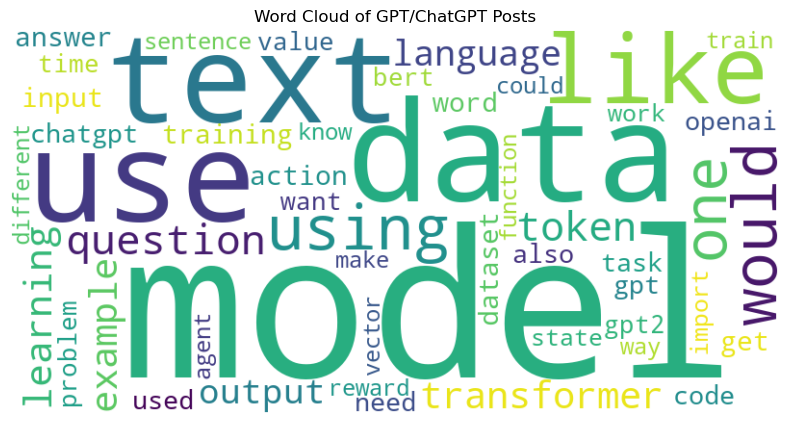

In [34]:
def get_top_words(text_series, n=50):
    """Extract top N frequent words from text series."""
    words = ' '.join(text_series.dropna()).split()
    word_counts = Counter(words)
    return pd.Series(word_counts).sort_values(ascending=False).head(n)

top_words_posts = get_top_words(gpt_post_df['PostText'], n=50)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_posts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of GPT/ChatGPT Posts')
plt.savefig('word_cloud_gpt.png')
plt.show()


We can easily observe that 'model', 'data', 'text', and 'use' are the most frequent words in the discussions about ChatGPT. These are common terms in AI or LLM field where we work with text data most of the time and try to build a model to unveil underlying relationships between words. Other noteworthy terms are 'language', 'gpt2' and 'openai' are all household names when we mention ChatGPT. 

### Plot the number of top used words

We draw a bar plot to visualize the appearances of top words in the discussions

/var/folders/dn/pf9_4vwj35g7wrw5hn5rlfn80000gn/T/ipykernel_21598/3599386832.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_words_posts.values, y=top_words_posts.index, palette='viridis')


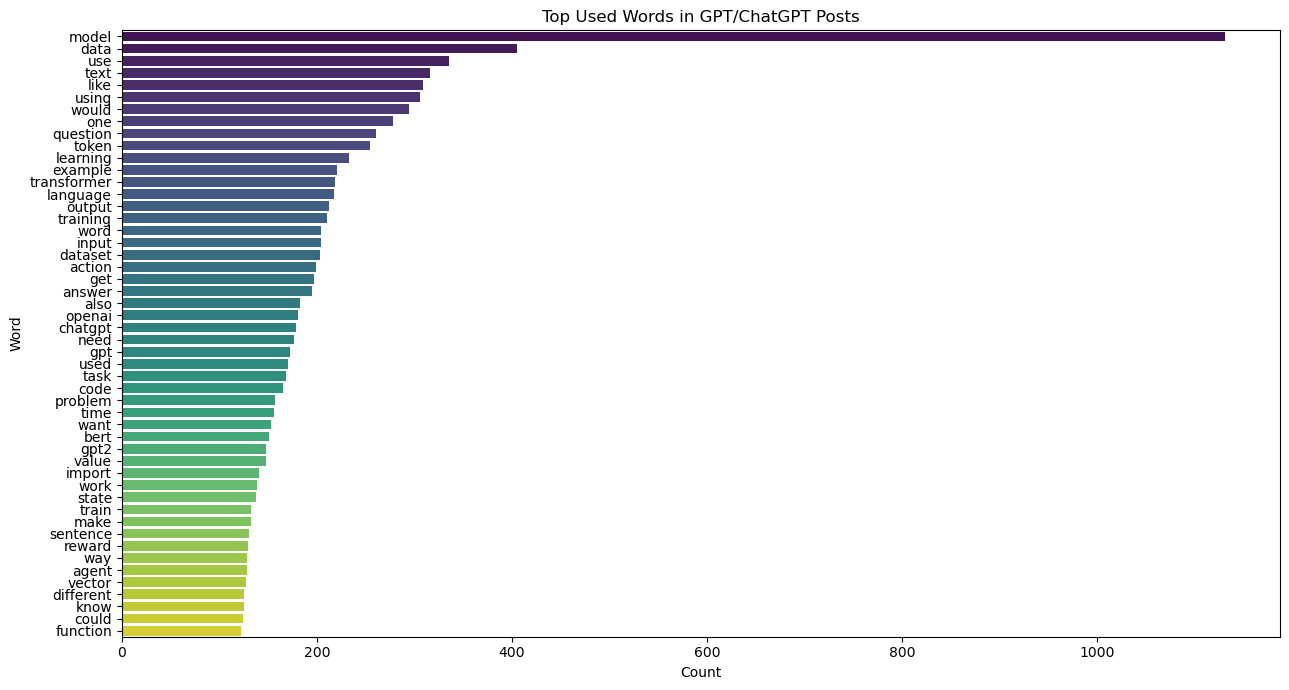

In [35]:
plt.figure(figsize=(13, 7))
sns.barplot(x=top_words_posts.values, y=top_words_posts.index, palette='viridis')
plt.title("Top Used Words in GPT/ChatGPT Posts")
plt.xlabel("Count")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

'Model' is the top 1 word that has a striking number of nearly 1200 appearances. Far behind is 'data' with roughly 400 times and 'use' with 360 times. We also notice some interesting keywords in this list such as token(300 times), transformer(220 times) and training(200 times), all of which are fundamentals terminologies in LLM development. 

### Lemmatize the comment data to prepare for analysis

We lemmatize the comments as the way we did with the post data. 

In [36]:
comments_grouped["LemmaComment"] = comments_grouped["CleanComment"].apply(lemmatize_text)
comments_grouped

PostId                                       CleanComment  \
0           5  this is a super theoretical ai question an int...   
1           7  list questions are usually not suited for stac...   
2          10  nice one nicholas another book from hastie and...   
3          14  as to the second part of your question i have ...   
4          15  this question is far too broad it may be salva...   
...       ...                                                ...   
31889  128501  thanks karl now i get the correct understandin...   
31890  128505  are you sure the bidirectional lstm isnt cheat...   
31891  128512  for seabornhistplot youre using multiplestack ...   
31892  128513  hi jaewookim welcome to the site have you trie...   
31893  128514  this fits stackoverflow better i think i think...   

                                            LemmaComment  
0      super theoretical question interesting discuss...  
1      list question usually suited stack exchange we...  
2      nice one nicholas another book hastie tibshira...  
3      second part question proposed discussion meta ...  
4      question far broad may salvaged restricting qu...  
...                                                  ...  
31889  thanks karl get correct understanding leaf var...  
31890  sure bidirectional lstm isnt cheating looking ...  
31891  seabornhistplot youre using multiplestack mean...  
31892  jaewookim welcome site tried looking public im...  
31893  fit stackoverflow better think think caused fa...  

[31894 rows x 3 columns]

We merge the post dataset and the comment dataset to extract relevant comments and perform further analysis on these two types. For the posts that do not have comments, we fill that with blank character. 

In [37]:
merged_df = pd.merge(gpt_post_df, comments_grouped, how='left', left_on='Id', right_on='PostId')
merged_df['CleanComment'] = merged_df['CleanComment'].fillna('')
merged_df['LemmaComment'] = merged_df['LemmaComment'].fillna('')
                
# Combine post text and comments text
merged_df['CombinedText'] = merged_df['PostText'] + ' ' + merged_df['CleanComment']
merged_df.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Id            491 non-null    int64         
 1   CreationDate  491 non-null    datetime64[ns]
 2   Score         491 non-null    int64         
 3   ViewCount     282 non-null    float64       
 4   Body          491 non-null    object        
 5   OwnerUserId   488 non-null    float64       
 6   Title         491 non-null    object        
 7   Tags          282 non-null    object        
 8   AnswerCount   282 non-null    float64       
 9   CommentCount  491 non-null    int64         
 10  CleanBody     491 non-null    object        
 11  CleanTitle    491 non-null    object        
 12  WordCount     491 non-null    int64         
 13  CodeCount     491 non-null    int64         
 14  has_code      491 non-null    bool          
 15  TagsList      491 non-null    object    

### Extract most frequently used words in the comments

We create a counter for each word and obtain the top 50 frequently used words. Then, we generate a wordcloud from the word list.

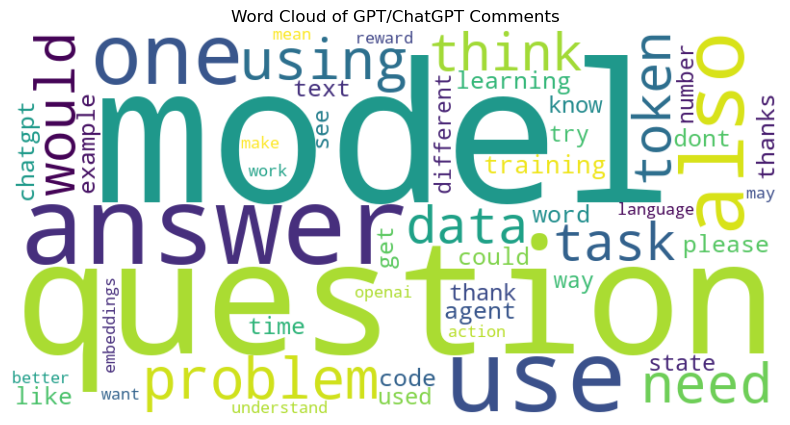

In [38]:
top_words_comments = get_top_words(merged_df['LemmaComment'], n=50)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words_comments)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of GPT/ChatGPT Comments')
plt.show()

We still get 'model' as the most frequently used word in the comments. However, it is also observed that less technical terms appear in the comments when compared to the posts. 

### Plot the number of top words used in the comments

We plot a bar chart to see the number of each word's appearance

/var/folders/dn/pf9_4vwj35g7wrw5hn5rlfn80000gn/T/ipykernel_21598/1099203260.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_words_comments.values, y=top_words_comments.index, palette='viridis')


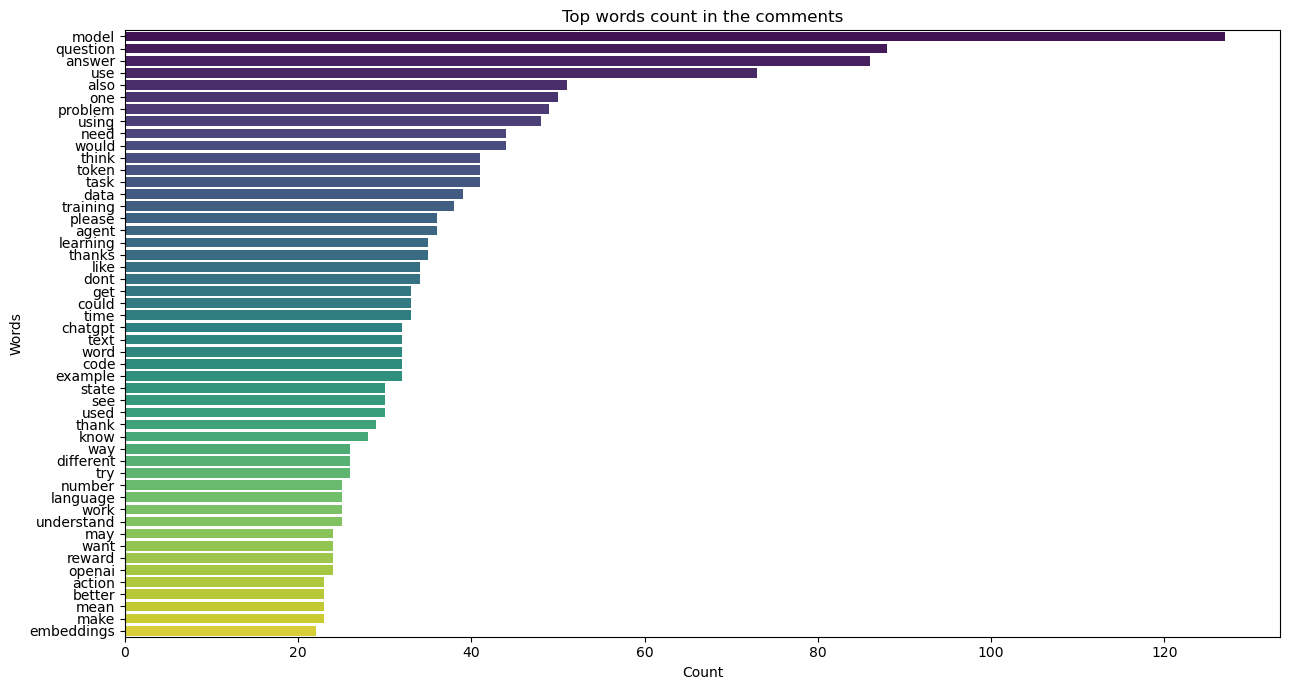

In [39]:
plt.figure(figsize=(13, 7))
sns.barplot(x=top_words_comments.values, y=top_words_comments.index, palette='viridis')
plt.xlabel("Count")
plt.ylabel("Words")
plt.title("Top words count in the comments")
plt.tight_layout()
plt.show()

The chart gives that 'model' is a dominant term with nearly 130 times of appearing in the comments. That is followed by 'question' and 'answer' with approximately 90 times. There are also many natural language text such as 'would', 'can', 'will', 'the', 'is', 'like', 'dont', 'get', 'could' which are expected in any discussion. 

### Most common words in the posts vs common words in the comments

We identify words that appear in both top words lists and draw a grouped bar chart to visualize most common words in the posts and in the comments

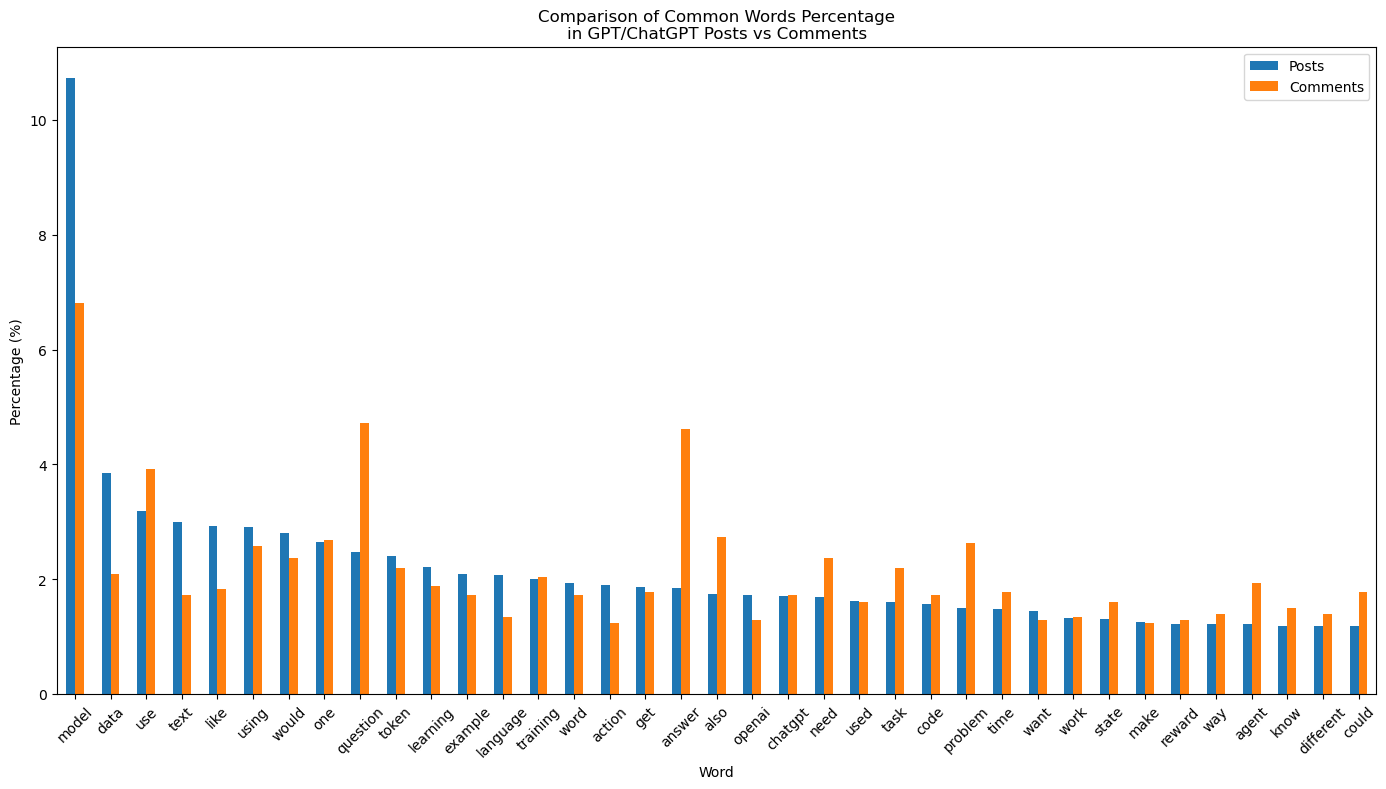

In [40]:
# Compute total counts for posts and comments
total_posts = top_words_posts.sum()
total_comments = top_words_comments.sum()

# Build a DataFrame that contains the percentages for each common word
data = []
for word in set(top_words_posts.index).intersection(set(top_words_comments.index)):
    data.append({
        'word': word,
        'Posts': top_words_posts[word] / total_posts * 100,
        'Comments': top_words_comments[word] / total_comments * 100
    })

df_percent = pd.DataFrame(data).sort_values(by='Posts', ascending=False)
df_percent.set_index('word', inplace=True)

# Plot the comparison as a grouped bar plot (percentages)
df_percent.plot(kind='bar', figsize=(14, 8))
plt.title("Comparison of Common Words Percentage\nin GPT/ChatGPT Posts vs Comments")
plt.xlabel("Word")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This grouped bar chart compares the percentage of common words appearing in GPT/ChatGPT posts versus their comments. For most words, the percentage is higher in posts than in comments, indicated by the taller blue bars. However, notable exceptions include words like "answer," "also," and "get," which show a higher percentage in comments (taller orange bars). This suggests that while posts tend to utilize a broader vocabulary of these common terms, comments might disproportionately focus on providing answers, adding additional points ("also"), or employing more informal language ("get").

## 6. Sentiment Analysis

In this section, we analyze the emotional tone in discussions about ChatGPT. Using nltk sentiment analysis, we classify posts and comments as positive, neutral, or negative based on their compound sentiment scores. The analysis reveals distinct word usage patterns across sentiment categories through visualization techniques including sentiment-specific word clouds and comparative distribution charts. We examine both the frequency and context of key terms within each sentiment group, highlighting which words are uniquely associated with positive versus negative discussions. This sentiment breakdown provides valuable insights into how the data science community perceives ChatGPT technology, showing the balance of enthusiasm, neutrality, and criticism in technical discussions about large language models.



We take a look again at the merged dataframe

In [41]:
merged_df.info()
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Id            491 non-null    int64         
 1   CreationDate  491 non-null    datetime64[ns]
 2   Score         491 non-null    int64         
 3   ViewCount     282 non-null    float64       
 4   Body          491 non-null    object        
 5   OwnerUserId   488 non-null    float64       
 6   Title         491 non-null    object        
 7   Tags          282 non-null    object        
 8   AnswerCount   282 non-null    float64       
 9   CommentCount  491 non-null    int64         
 10  CleanBody     491 non-null    object        
 11  CleanTitle    491 non-null    object        
 12  WordCount     491 non-null    int64         
 13  CodeCount     491 non-null    int64         
 14  has_code      491 non-null    bool          
 15  TagsList      491 non-null    object    

Id            CreationDate  Score  ViewCount  \
0   5830 2015-05-19 02:09:13.700      2      518.0   
1  13820 2016-09-02 11:15:19.617      1     9808.0   
2  16067 2017-01-04 14:17:56.523      8        NaN   
3  16072 2017-01-04 17:36:53.577      4        NaN   
4  16980 2017-02-14 23:50:35.533      1        NaN   

                                                Body  OwnerUserId  \
0  <p>I was informed of 5 java NLP libraries.</p>...          NaN   
1  <p>I installed orange version 3 yesterday. I d...      24007.0   
2  <p>There are multiple ways to approach solving...        836.0   
3  <p>What you are looking for is called <em>Rein...       8820.0   
4  <p>You could use the same reward function that...      18626.0   

                                               Title           Tags  \
0  How do I best parse ECOG scores in cancer clin...     |nlp|java|   
1              Target variable problem :- Classifier  |data|orange|   
2                                                               NaN   
3                                                               NaN   
4                                                               NaN   

   AnswerCount  CommentCount  ... WordCount CodeCount  has_code  \
0          0.0             0  ...      1577         1      True   
1          1.0             0  ...       714         1      True   
2          NaN             0  ...       467         0     False   
3          NaN             0  ...        91         0     False   
4          NaN             8  ...       155         0     False   

         TagsList  Year                                           PostText  \
0     [nlp, java]  2015  informed java nlp library apache ctakes metama...   
1  [data, orange]  2016  installed orange version yesterday defined var...   
2              []  2017  multiple way approach solving game playing pro...   
3              []  2017  looking called reinforcement learning universi...   
4              []  2017  could use reward function openais inverted pen...   

    PostId                                       CleanComment  \
0      NaN                                                      
1      NaN                                                      
2      NaN                                                      
3      NaN                                                      
4  16980.0  i think answer is more applicable for ops prob...   

                                        LemmaComment  \
0                                                      
1                                                      
2                                                      
3                                                      
4  think answer applicable ops problem mine treat...   

                                        CombinedText  
0  informed java nlp library apache ctakes metama...  
1  installed orange version yesterday defined var...  
2  multiple way approach solving game playing pro...  
3  looking called reinforcement learning universi...  
4  could use reward function openais inverted pen...  

[5 rows x 22 columns]

### Count the total number of words of a post and its comment

In [42]:
merged_df["TotalWordCount"] = (merged_df["CleanBody"] + " " + merged_df["CleanTitle"] + " " + merged_df["CleanComment"]).apply(count_words)

sentiment_df = merged_df.drop(columns=["Body", "Title", "Tags", "AnswerCount", "WordCount", "has_code", "PostId", "ViewCount"])
sentiment_df.info()
sentiment_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Id              491 non-null    int64         
 1   CreationDate    491 non-null    datetime64[ns]
 2   Score           491 non-null    int64         
 3   OwnerUserId     488 non-null    float64       
 4   CommentCount    491 non-null    int64         
 5   CleanBody       491 non-null    object        
 6   CleanTitle      491 non-null    object        
 7   CodeCount       491 non-null    int64         
 8   TagsList        491 non-null    object        
 9   Year            491 non-null    int32         
 10  PostText        491 non-null    object        
 11  CleanComment    491 non-null    object        
 12  LemmaComment    491 non-null    object        
 13  CombinedText    491 non-null    object        
 14  TotalWordCount  491 non-null    int64         
dtypes: dat

Id            CreationDate  Score  OwnerUserId  CommentCount  \
0   5830 2015-05-19 02:09:13.700      2          NaN             0   
1  13820 2016-09-02 11:15:19.617      1      24007.0             0   
2  16067 2017-01-04 14:17:56.523      8        836.0             0   
3  16072 2017-01-04 17:36:53.577      4       8820.0             0   
4  16980 2017-02-14 23:50:35.533      1      18626.0             8   

                                           CleanBody  \
0  i was informed of 5 java nlp libraries\n\n\nap...   
1  i installed orange version 3 yesterday i defin...   
2  there are multiple ways to approach solving ga...   
3  what you are looking for is called reinforceme...   
4  you could use the same reward function that op...   

                                          CleanTitle  CodeCount  \
0  how do i best parse ecog scores in cancer clin...          1   
1                target variable problem  classifier          1   
2                                                             0   
3                                                             0   
4                                                             0   

         TagsList  Year                                           PostText  \
0     [nlp, java]  2015  informed java nlp library apache ctakes metama...   
1  [data, orange]  2016  installed orange version yesterday defined var...   
2              []  2017  multiple way approach solving game playing pro...   
3              []  2017  looking called reinforcement learning universi...   
4              []  2017  could use reward function openais inverted pen...   

                                        CleanComment  \
0                                                      
1                                                      
2                                                      
3                                                      
4  i think answer is more applicable for ops prob...   

                                        LemmaComment  \
0                                                      
1                                                      
2                                                      
3                                                      
4  think answer applicable ops problem mine treat...   

                                        CombinedText  TotalWordCount  
0  informed java nlp library apache ctakes metama...            1591  
1  installed orange version yesterday defined var...             718  
2  multiple way approach solving game playing pro...             467  
3  looking called reinforcement learning universi...              91  
4  could use reward function openais inverted pen...             458

###  Calculate polarity score and Classify the sentiment

We will use the function `get_sentiment_score()` to calculate the polarity of each text and `classify_sentiment` to assign a label to each instance based on the score.

In [43]:
#Calulate and classify sentiment score of the posts and their comments
sentiment_df["PostScore"] = sentiment_df["PostText"].apply(get_sentiment_score)
sentiment_df["CommentScore"] = sentiment_df["LemmaComment"].apply(get_sentiment_score)
sentiment_df["PostSentiment"] = sentiment_df["PostScore"].apply(classify_sentiment)
sentiment_df["CommentSentiment"] = sentiment_df["CommentScore"].apply(classify_sentiment)

sentiment_df

Id            CreationDate  Score  OwnerUserId  CommentCount  \
0      5830 2015-05-19 02:09:13.700      2          NaN             0   
1     13820 2016-09-02 11:15:19.617      1      24007.0             0   
2     16067 2017-01-04 14:17:56.523      8        836.0             0   
3     16072 2017-01-04 17:36:53.577      4       8820.0             0   
4     16980 2017-02-14 23:50:35.533      1      18626.0             8   
..      ...                     ...    ...          ...           ...   
486  128424 2024-03-24 05:52:56.803      0     161742.0             1   
487  128438 2024-03-25 15:44:23.787      0     161771.0             0   
488  128490 2024-03-29 09:05:09.473      0     143103.0             0   
489  128492 2024-03-29 11:55:58.047      0      76453.0             0   
490  128493 2024-03-29 12:20:26.163      1     143103.0             1   

                                             CleanBody  \
0    i was informed of 5 java nlp libraries\n\n\nap...   
1    i installed orange version 3 yesterday i defin...   
2    there are multiple ways to approach solving ga...   
3    what you are looking for is called reinforceme...   
4    you could use the same reward function that op...   
..                                                 ...   
486  what do you think of these steps and where can...   
487  so total sas noob here and i dont like it al a...   
488  maybe i just dont understand the functionality...   
489  i want to finetune an slm like phi2 through th...   
490  had asked on reddit too didnt expect an answer...   

                                            CleanTitle  CodeCount  \
0    how do i best parse ecog scores in cancer clin...          1   
1                  target variable problem  classifier          1   
2                                                               0   
3                                                               0   
4                                                               0   
..                                                 ...        ...   
486    is this how you would go about this nlp project          0   
487  sas how to replace a value in column two in a ...          4   
488                      searching chatgpt transcripts          0   
489  how is a causal language model correctly finet...          3   
490                                                             0   

                                              TagsList  Year  \
0                                          [nlp, java]  2015   
1                                       [data, orange]  2016   
2                                                   []  2017   
3                                                   []  2017   
4                                                   []  2017   
..                                                 ...   ...   
486  [nlp, text-classification, automatic-summariza...  2024   
487                     [dataset, transformation, sas]  2024   
488    [information-retrieval, tools, search, chatgpt]  2024   
489                  [nlp, language-model, finetuning]  2024   
490                                                 []  2024   

                                              PostText  \
0    informed java nlp library apache ctakes metama...   
1    installed orange version yesterday defined var...   
2    multiple way approach solving game playing pro...   
3    looking called reinforcement learning universi...   
4    could use reward function openais inverted pen...   
..                                                 ...   
486  think step find help project business class as...   
487  total sa noob dont like far tried different me...   
488  maybe dont understand functionality web versio...   
489  want finetune slm like phi2 huggingface api do...   
490  asked reddit didnt expect answer easy chatgpt ...   

                                          CleanComment  \
0                                                        
1                       

Now that we only focus on the sentiments of each discussion, we no longer need the text data in this section so we ill drop the redundant columns for better management.

In [44]:
sentiment_df = sentiment_df.drop(columns=["CleanBody", "CleanTitle", "CleanComment","CombinedText"])
sentiment_df.info()
sentiment_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Id                491 non-null    int64         
 1   CreationDate      491 non-null    datetime64[ns]
 2   Score             491 non-null    int64         
 3   OwnerUserId       488 non-null    float64       
 4   CommentCount      491 non-null    int64         
 5   CodeCount         491 non-null    int64         
 6   TagsList          491 non-null    object        
 7   Year              491 non-null    int32         
 8   PostText          491 non-null    object        
 9   LemmaComment      491 non-null    object        
 10  TotalWordCount    491 non-null    int64         
 11  PostScore         491 non-null    float64       
 12  CommentScore      491 non-null    float64       
 13  PostSentiment     491 non-null    object        
 14  CommentSentiment  491 non-

Id            CreationDate  Score  OwnerUserId  CommentCount  CodeCount  \
0   5830 2015-05-19 02:09:13.700      2          NaN             0          1   
1  13820 2016-09-02 11:15:19.617      1      24007.0             0          1   
2  16067 2017-01-04 14:17:56.523      8        836.0             0          0   
3  16072 2017-01-04 17:36:53.577      4       8820.0             0          0   
4  16980 2017-02-14 23:50:35.533      1      18626.0             8          0   

         TagsList  Year                                           PostText  \
0     [nlp, java]  2015  informed java nlp library apache ctakes metama...   
1  [data, orange]  2016  installed orange version yesterday defined var...   
2              []  2017  multiple way approach solving game playing pro...   
3              []  2017  looking called reinforcement learning universi...   
4              []  2017  could use reward function openais inverted pen...   

                                        LemmaComment  TotalWordCount  \
0                                                               1591   
1                                                                718   
2                                                                467   
3                                                                 91   
4  think answer applicable ops problem mine treat...             458   

   PostScore  CommentScore PostSentiment CommentSentiment  
0    -0.9647        0.0000      Negative          Neutral  
1     0.9186        0.0000      Positive          Neutral  
2     0.9860        0.0000      Positive          Neutral  
3     0.5267        0.0000      Positive          Neutral  
4     0.8834        0.9881      Positive         Positive

### Wordcloud for each sentiment category

We group the posts by sentiment, identify the top used words in each category and then generate wordclouds from them. 

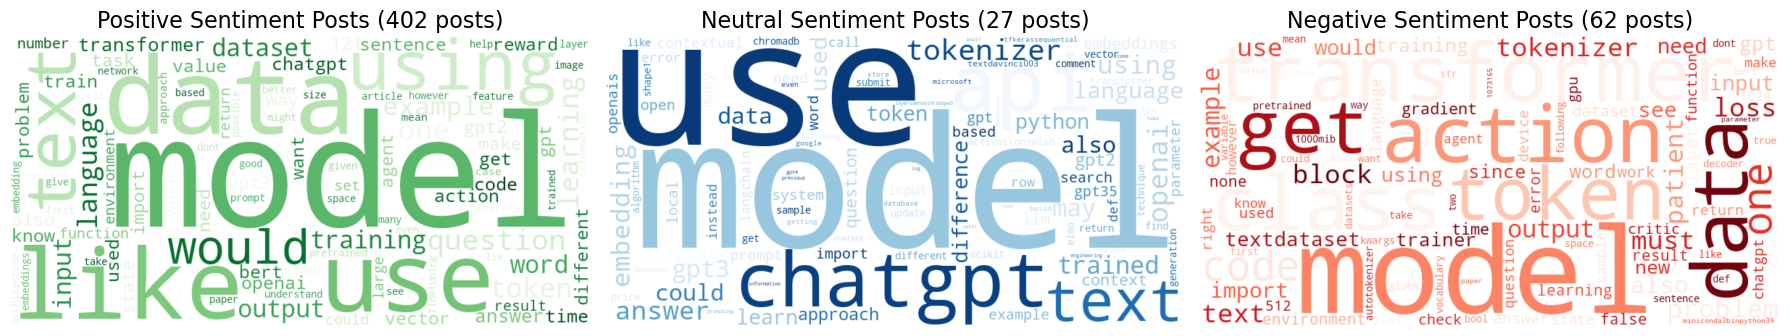

In [45]:
# Create separate dataframes for each sentiment category
positive_posts = sentiment_df[sentiment_df['PostSentiment'] == 'Positive']
neutral_posts = sentiment_df[sentiment_df['PostSentiment'] == 'Neutral']
negative_posts = sentiment_df[sentiment_df['PostSentiment'] == 'Negative']

# Prepare the word clouds by sentiment
plt.figure(figsize=(18, 5))

# Define custom color maps for each sentiment
positive_colormap = plt.cm.Greens
neutral_colormap = plt.cm.Blues
negative_colormap = plt.cm.Reds

# Generate top words for each sentiment
positive_words = get_top_words(positive_posts['PostText'], n=100)
neutral_words = get_top_words(neutral_posts['PostText'], n=100)
negative_words = get_top_words(negative_posts['PostText'], n=100)

# Create word clouds for each sentiment
plt.subplot(1, 3, 1)
if not positive_words.empty:
    positive_cloud = WordCloud(width=800, height=400, 
                             background_color='white',
                             colormap=positive_colormap,
                             max_words=100).generate_from_frequencies(positive_words)
    plt.imshow(positive_cloud, interpolation='bilinear')
    plt.title(f'Positive Sentiment Posts ({len(positive_posts)} posts)', fontsize=16)
    plt.axis('off')
else:
    plt.text(0.5, 0.5, "No positive posts", fontsize=16, ha='center')
    plt.axis('off')

plt.subplot(1, 3, 2)
if not neutral_words.empty:
    neutral_cloud = WordCloud(width=800, height=400, 
                            background_color='white',
                            colormap=neutral_colormap,
                            max_words=100).generate_from_frequencies(neutral_words)
    plt.imshow(neutral_cloud, interpolation='bilinear')
    plt.title(f'Neutral Sentiment Posts ({len(neutral_posts)} posts)', fontsize=16)
    plt.axis('off')
else:
    plt.text(0.5, 0.5, "No neutral posts", fontsize=16, ha='center')
    plt.axis('off')

plt.subplot(1, 3, 3)
if not negative_words.empty:
    negative_cloud = WordCloud(width=800, height=400, 
                             background_color='white',
                             colormap=negative_colormap,
                             max_words=100).generate_from_frequencies(negative_words)
    plt.imshow(negative_cloud, interpolation='bilinear')
    plt.title(f'Negative Sentiment Posts ({len(negative_posts)} posts)', fontsize=16)
    plt.axis('off')
else:
    plt.text(0.5, 0.5, "No negative posts", fontsize=16, ha='center')
    plt.axis('off')

plt.tight_layout()
plt.savefig('sentiment_wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()


- Positive Sentiment (402 posts): The most prominent word is "model" (in green), suggesting a focus on machine learning or AI models. Other frequent terms include "training," "data," "use," "like," and "language," indicating discussions around training AI models, datasets, and natural language processing. The large number of posts suggests strong interest or optimism in these topics.
- Neutral Sentiment (27 posts): The word "model" remains prominent (in blue), alongside "use," "data," and "training." Additional terms like "get," "open," and "system" appear, hinting at neutral discussions about model usage, data handling, and system implementation. The lower post count reflects less engagement compared to positive sentiment.
- Negative Sentiment (62 posts): Again, "model" stands out (in red), with "data," "use," and "training" also frequent. Terms like "error," "problem," "loss," and "need" suggest challenges or dissatisfaction, possibly related to model performance issues or data quality. The moderate post count indicates some frustration but less than the positive sentiment volume.

Overall, "model," "data," "use," and "training" are central across all sentiments, reflecting a common focus on AI development. Positive sentiment dominates, with neutral and negative sentiments showing more specific concerns or neutral observations.

### Distribution of post on different sentiment categories

We create a bar chart to visualize the number of post in each sentiment category

Distribution of sentiments in posts:
PostSentiment
Positive    402
Negative     62
Neutral      27
Name: count, dtype: int64


/var/folders/dn/pf9_4vwj35g7wrw5hn5rlfn80000gn/T/ipykernel_21598/2425395913.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sentiment_df, x='PostSentiment', palette={'Positive': '#5cb85c', 'Neutral': '#5bc0de', 'Negative': '#d9534f'})


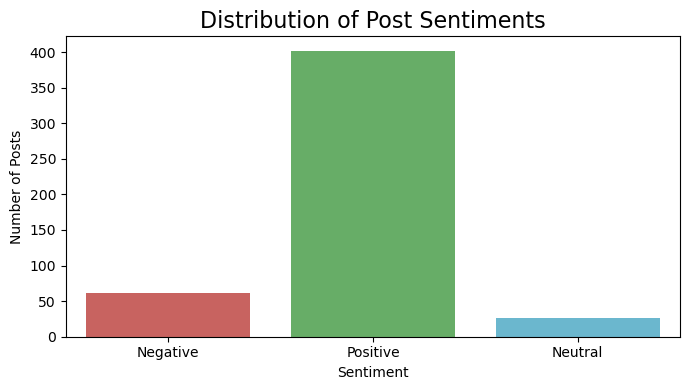

In [ ]:

# Print sentiment distribution
sentiment_counts = sentiment_df['PostSentiment'].value_counts()
print("Distribution of sentiments in posts:")
print(sentiment_counts)

# Create a bar chart of sentiment distribution
plt.figure(figsize=(7, 4))
sns.countplot(data=sentiment_df, x='PostSentiment', palette={'Positive': '#5cb85c', 'Neutral': '#5bc0de', 'Negative': '#d9534f'}, __annotations__=True)
plt.title('Distribution of Post Sentiments', fontsize=16)
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.show()

### Words Sentiment Proportion

We concatenate the top words in each sentiment category and then count the appearance of each word in all categories. We use a stacked bar chart to demonstrate the percentage of each word's presence in every sentiment category. 

/var/folders/dn/pf9_4vwj35g7wrw5hn5rlfn80000gn/T/ipykernel_21598/3618095927.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  word_sentiment_df = word_sentiment_df.fillna(0)


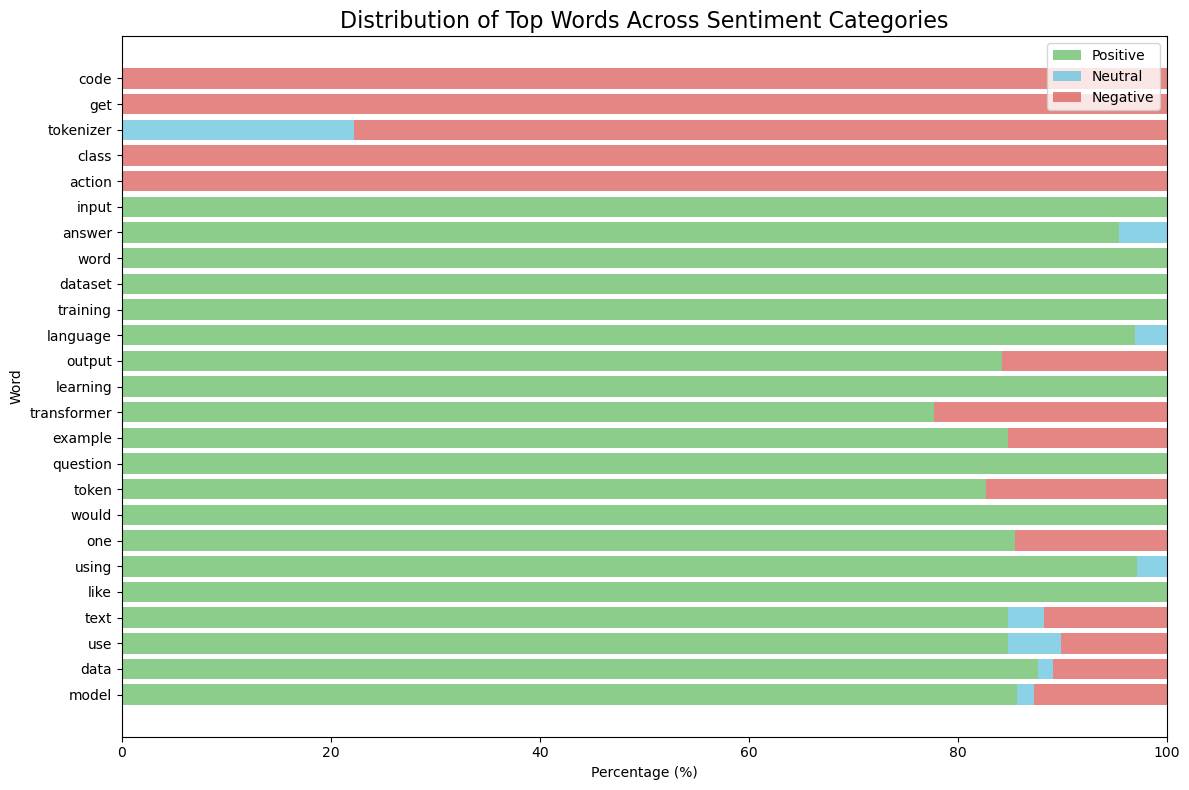

In [47]:


# Get top 20 words for each sentiment category
top_pos_words = positive_words.head(20)
top_neu_words = neutral_words.head(20)
top_neg_words = negative_words.head(20)

# Combine all unique words from the top words in each category
all_top_words = list(set(top_pos_words.index) | set(top_neu_words.index) | set(top_neg_words.index))

# Create a dataframe with word counts by sentiment
word_sentiment_df = pd.DataFrame(index=all_top_words, columns=['Positive', 'Neutral', 'Negative'])
word_sentiment_df = word_sentiment_df.fillna(0)

# Fill in the values
for word in all_top_words:
    if word in top_pos_words:
        word_sentiment_df.loc[word, 'Positive'] = top_pos_words[word]
    if word in top_neu_words:
        word_sentiment_df.loc[word, 'Neutral'] = top_neu_words[word]
    if word in top_neg_words:
        word_sentiment_df.loc[word, 'Negative'] = top_neg_words[word]

# Calculate total mentions of each word
word_sentiment_df['Total'] = word_sentiment_df.sum(axis=1)

# Sort by total mentions
word_sentiment_df = word_sentiment_df.sort_values('Total', ascending=False).head(25)

# Calculate percentages for each sentiment
for col in ['Positive', 'Neutral', 'Negative']:
    word_sentiment_df[f'{col}_pct'] = word_sentiment_df[col] / word_sentiment_df['Total'] * 100

# Create a stacked percentage bar chart
plt.figure(figsize=(12, 8))
words = word_sentiment_df.index
pos_pct = word_sentiment_df['Positive_pct']
neu_pct = word_sentiment_df['Neutral_pct']
neg_pct = word_sentiment_df['Negative_pct']

# Create the stacked bars
plt.barh(words, pos_pct, color='#5cb85c', alpha=0.7, label='Positive')
plt.barh(words, neu_pct, left=pos_pct, color='#5bc0de', alpha=0.7, label='Neutral')
plt.barh(words, neg_pct, left=pos_pct+neu_pct, color='#d9534f', alpha=0.7, label='Negative')

plt.xlabel('Percentage (%)')
plt.ylabel('Word')
plt.title('Distribution of Top Words Across Sentiment Categories', fontsize=16)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('sentiment_words_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

We can see from the chart that most top words incur positive reactions, some of which dominate words like 'input', 'word', 'dataset' and 'training'. Looking ar the top of the chart, we still observe words fully assigned with negativity. 'Code', 'tokenizer', 'class' are such striking examples,

### Distribution of comments based on sentiments

We identify how many comments there are in each sentiment category and generate word cloud

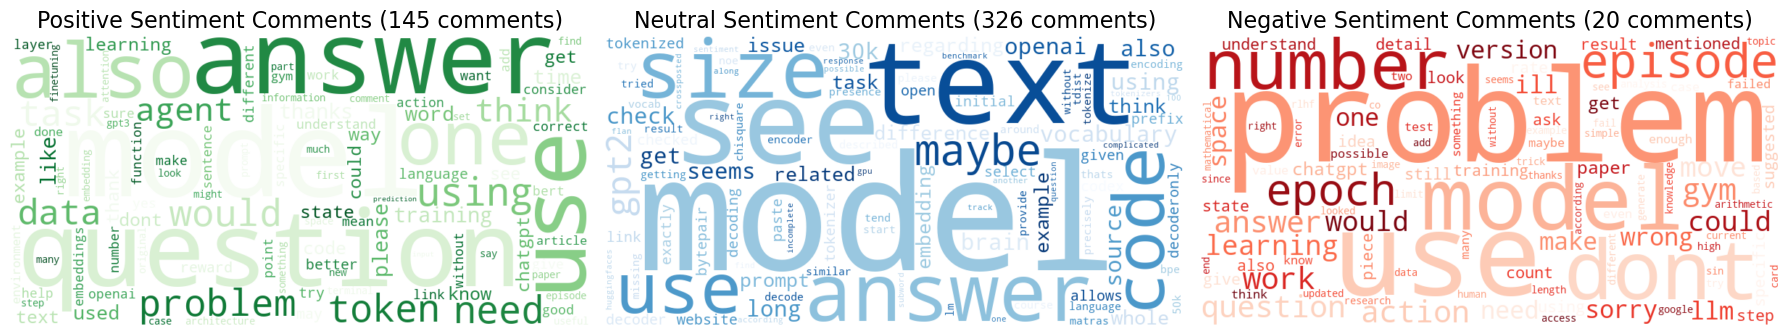

In [48]:
# Create separate dataframes for each sentiment category
positive_posts = sentiment_df[sentiment_df['CommentSentiment'] == 'Positive']
neutral_posts = sentiment_df[sentiment_df['CommentSentiment'] == 'Neutral']
negative_posts = sentiment_df[sentiment_df['CommentSentiment'] == 'Negative']

# Prepare the word clouds by sentiment
plt.figure(figsize=(18, 5))

# Define custom color maps for each sentiment
positive_colormap = plt.cm.Greens
neutral_colormap = plt.cm.Blues
negative_colormap = plt.cm.Reds

# Generate top words for each sentiment
positive_words = get_top_words(positive_posts['LemmaComment'], n=100)
neutral_words = get_top_words(neutral_posts['LemmaComment'], n=100)
negative_words = get_top_words(negative_posts['LemmaComment'], n=100)

# Create word clouds for each sentiment
plt.subplot(1, 3, 1)
if not positive_words.empty:
    positive_cloud = WordCloud(width=800, height=400, 
                             background_color='white',
                             colormap=positive_colormap,
                             max_words=100).generate_from_frequencies(positive_words)
    plt.imshow(positive_cloud, interpolation='bilinear')
    plt.title(f'Positive Sentiment Comments ({len(positive_posts)} comments)', fontsize=16)
    plt.axis('off')
else:
    plt.text(0.5, 0.5, "No positive comments", fontsize=16, ha='center')
    plt.axis('off')

plt.subplot(1, 3, 2)
if not neutral_words.empty:
    neutral_cloud = WordCloud(width=800, height=400, 
                            background_color='white',
                            colormap=neutral_colormap,
                            max_words=100).generate_from_frequencies(neutral_words)
    plt.imshow(neutral_cloud, interpolation='bilinear')
    plt.title(f'Neutral Sentiment Comments ({len(neutral_posts)} comments)', fontsize=16)
    plt.axis('off')
else:
    plt.text(0.5, 0.5, "No neutral comments", fontsize=16, ha='center')
    plt.axis('off')

plt.subplot(1, 3, 3)
if not negative_words.empty:
    negative_cloud = WordCloud(width=800, height=400, 
                             background_color='white',
                             colormap=negative_colormap,
                             max_words=100).generate_from_frequencies(negative_words)
    plt.imshow(negative_cloud, interpolation='bilinear')
    plt.title(f'Negative Sentiment Comments ({len(negative_posts)} comments)', fontsize=16)
    plt.axis('off')
else:
    plt.text(0.5, 0.5, "No negative comments", fontsize=16, ha='center')
    plt.axis('off')

plt.tight_layout()
plt.show()


- Positive Sentiment (145 comments): The most prominent word is "answer" (in green), suggesting satisfaction with responses or solutions. Other frequent terms include "model," "question," "use," "data," "problem," "training," "like," and "token," indicating discussions around AI models, problem-solving, and data usage. The moderate comment count reflects a positive but not dominant sentiment.
- Neutral Sentiment (326 comments): The word "model" stands out (in blue), alongside "use," "text," "see," "think," "get," "question," and "answer." Terms like "maybe," "could," "seems," and "please" suggest neutral inquiries or considerations about model usage and text processing. The high comment count indicates significant neutral engagement.
- Negative Sentiment (20 comments): The word "problem" is prominent (in red), with "error," "failed," "sorry," and "don't" also notable, pointing to issues or dissatisfaction, possibly with model performance or results. Other terms like "understand" and "need" suggest frustration or requests for clarification. The low comment count indicates limited negative feedback.

Overall, "model," "use," "answer," and "question" are central across sentiments, with neutral comments dominating, positive comments showing approval, and negative comments highlighting challenges.

Distribution of sentiments in comments:
CommentSentiment
Neutral     326
Positive    145
Negative     20
Name: count, dtype: int64


/var/folders/dn/pf9_4vwj35g7wrw5hn5rlfn80000gn/T/ipykernel_21598/4155792231.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sentiment_df, x='CommentSentiment', palette={'Positive': '#5cb85c', 'Neutral': '#5bc0de', 'Negative': '#d9534f'})


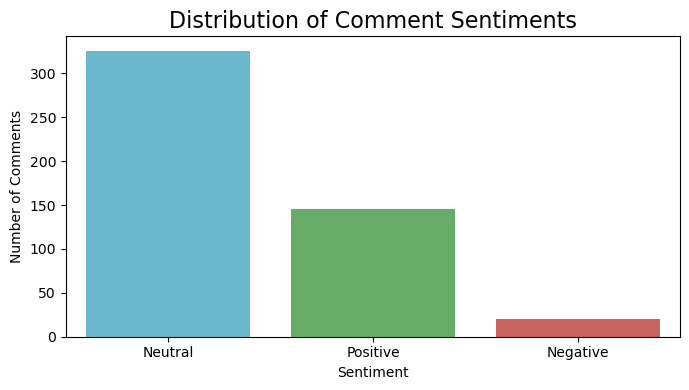

In [49]:
# Print sentiment distribution
sentiment_counts = sentiment_df['CommentSentiment'].value_counts()
print("Distribution of sentiments in comments:")
print(sentiment_counts)

# Create a bar chart of sentiment distribution
plt.figure(figsize=(7, 4))
sns.countplot(data=sentiment_df, x='CommentSentiment', palette={'Positive': '#5cb85c', 'Neutral': '#5bc0de', 'Negative': '#d9534f'})
plt.title('Distribution of Comment Sentiments', fontsize=16)
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.tight_layout()
plt.show()


### Words Sentiment Proportion in Comments

/var/folders/dn/pf9_4vwj35g7wrw5hn5rlfn80000gn/T/ipykernel_21598/2290968868.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  word_sentiment_df = word_sentiment_df.fillna(0)


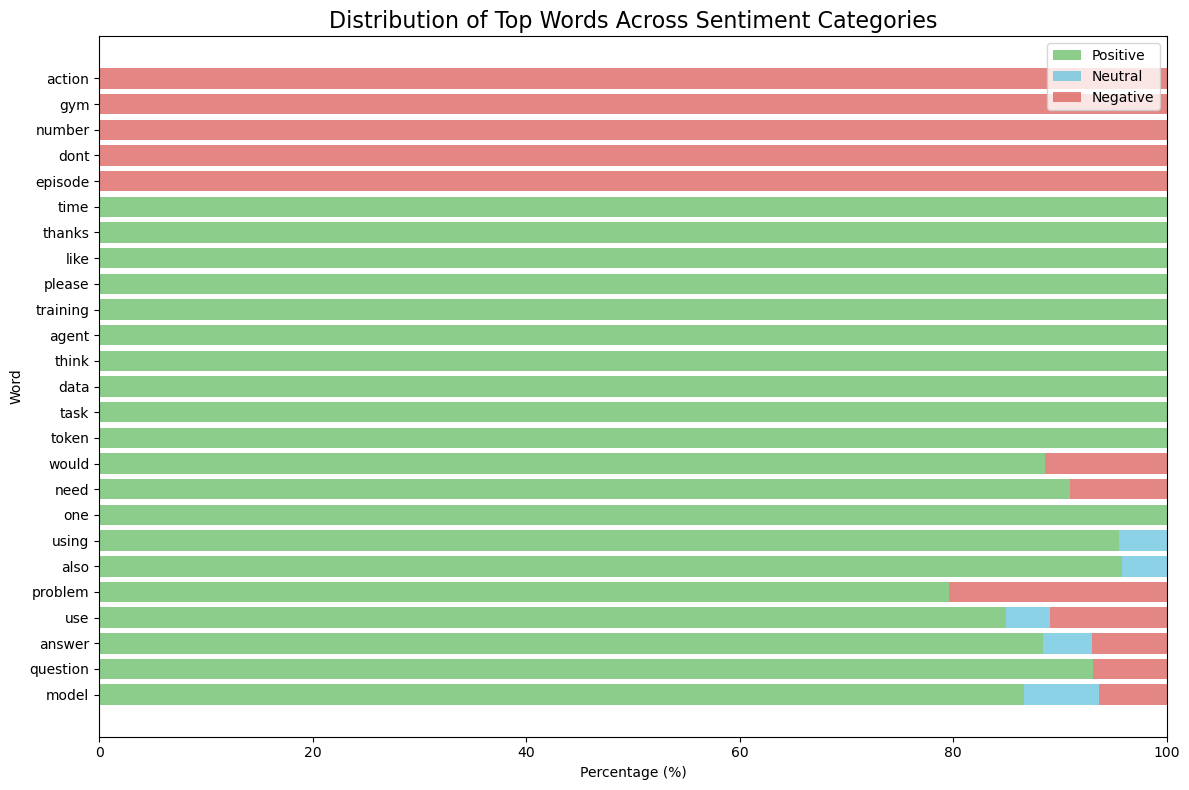

In [50]:


# Get top 20 words for each sentiment category
top_pos_words = positive_words.head(20)
top_neu_words = neutral_words.head(20)
top_neg_words = negative_words.head(20)

# Combine all unique words from the top words in each category
all_top_words = list(set(top_pos_words.index) | set(top_neu_words.index) | set(top_neg_words.index))

# Create a dataframe with word counts by sentiment
word_sentiment_df = pd.DataFrame(index=all_top_words, columns=['Positive', 'Neutral', 'Negative'])
word_sentiment_df = word_sentiment_df.fillna(0)

# Fill in the values
for word in all_top_words:
    if word in top_pos_words:
        word_sentiment_df.loc[word, 'Positive'] = top_pos_words[word]
    if word in top_neu_words:
        word_sentiment_df.loc[word, 'Neutral'] = top_neu_words[word]
    if word in top_neg_words:
        word_sentiment_df.loc[word, 'Negative'] = top_neg_words[word]

# Calculate total mentions of each word
word_sentiment_df['Total'] = word_sentiment_df.sum(axis=1)

# Sort by total mentions
word_sentiment_df = word_sentiment_df.sort_values('Total', ascending=False).head(25)

# Calculate percentages for each sentiment
for col in ['Positive', 'Neutral', 'Negative']:
    word_sentiment_df[f'{col}_pct'] = word_sentiment_df[col] / word_sentiment_df['Total'] * 100

# Create a stacked percentage bar chart
plt.figure(figsize=(12, 8))
words = word_sentiment_df.index
pos_pct = word_sentiment_df['Positive_pct']
neu_pct = word_sentiment_df['Neutral_pct']
neg_pct = word_sentiment_df['Negative_pct']

# Create the stacked bars
plt.barh(words, pos_pct, color='#5cb85c', alpha=0.7, label='Positive')
plt.barh(words, neu_pct, left=pos_pct, color='#5bc0de', alpha=0.7, label='Neutral')
plt.barh(words, neg_pct, left=pos_pct+neu_pct, color='#d9534f', alpha=0.7, label='Negative')

plt.xlabel('Percentage (%)')
plt.ylabel('Word')
plt.title('Distribution of Top Words Across Sentiment Categories', fontsize=16)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

The pattern does not change much for the comments data. Most top words have positive sentiments and few of them have mixed reactions. The observation for negative words are even more striking where the top 5 words 100% are mentioned in sentences with negative sentiments. 

### Comparison of number of posts and comments in each sentiment category

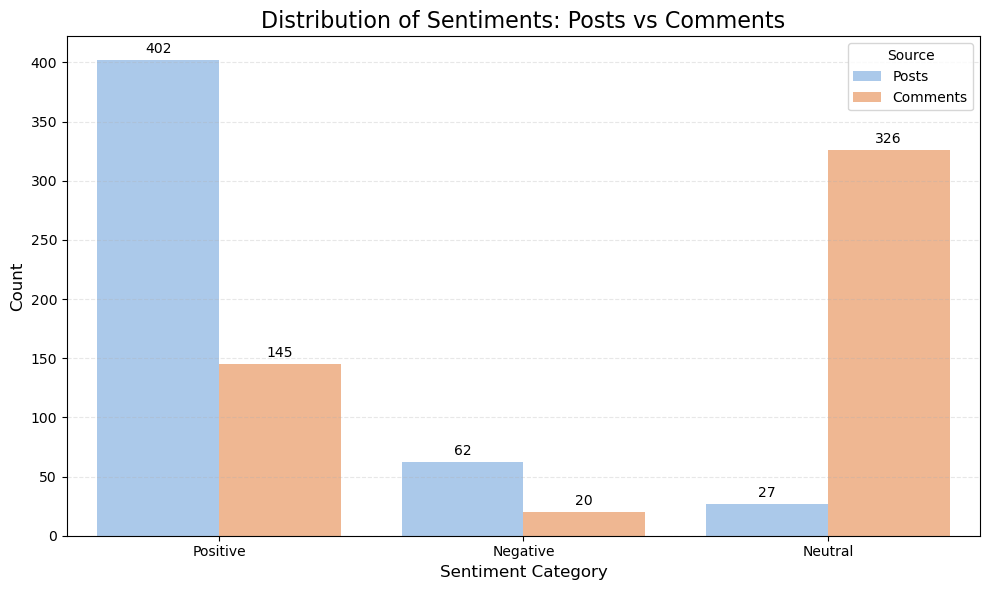

In [51]:
# Create a dataframe to hold the sentiment distribution for both posts and comments
post_sentiment_counts = sentiment_df['PostSentiment'].value_counts().reset_index()
post_sentiment_counts.columns = ['Sentiment', 'Count']
post_sentiment_counts['Source'] = 'Posts'

comment_sentiment_counts = sentiment_df['CommentSentiment'].value_counts().reset_index()
comment_sentiment_counts.columns = ['Sentiment', 'Count']
comment_sentiment_counts['Source'] = 'Comments'

# Combine the dataframes
sentiment_comparison_df = pd.concat([post_sentiment_counts, comment_sentiment_counts])

# Define the color palette for sentiments
sentiment_colors = {'Positive': '#5cb85c', 'Neutral': '#5bc0de', 'Negative': '#d9534f'}

# Create the grouped bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Sentiment', 
    y='Count', 
    hue='Source', 
    data=sentiment_comparison_df,
    palette='pastel'
)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', padding=3)

# Customize the chart
plt.title('Distribution of Sentiments: Posts vs Comments', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Source')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# Show the plot
plt.savefig('sentiment_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Posts show a significantly higher number of positive sentiment (402) compared to negative (62) and neutral (27) sentiments. This suggests that the initial content being shared tends to lean towards a positive outlook.
In contrast, comments exhibit the highest count in the neutral category (326), followed by positive (145) and then negative (20). This could indicate that discussions in the comment sections are often more objective, factual, or less emotionally charged compared to the initial posts.

### Grouped bar charts to display common words in posts and comments based on sentiment category

We extract top words in each sentiment category for post and comments data separately. Then we filter simmilar words in posts and comments from the list and then plot them onto a bar chart

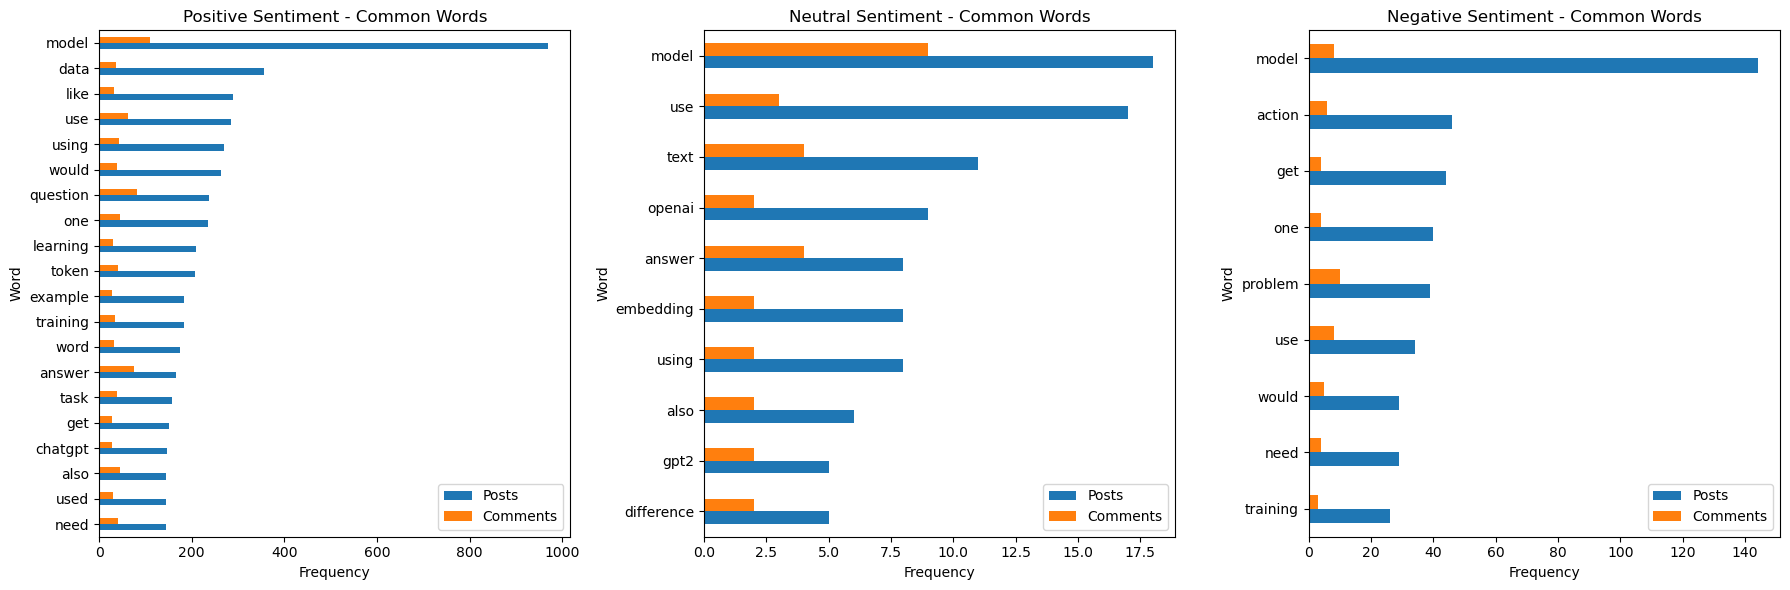

In [52]:
# Define sentiments to analyze
sentiments = ['Positive', 'Neutral', 'Negative']

# Create subplots for each sentiment category
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, sentiment in enumerate(sentiments):
    # Filter the dataframe for posts and comments with the current sentiment
    posts_subset = sentiment_df[sentiment_df['PostSentiment'] == sentiment]
    comments_subset = sentiment_df[sentiment_df['CommentSentiment'] == sentiment]
    
    # Extract the top words (you can adjust the number "n" as needed)
    post_words = get_top_words(posts_subset['PostText'], n=30)
    comment_words = get_top_words(comments_subset['LemmaComment'], n=30)
    
    # Find common words between posts and comments for this sentiment
    common_words = set(post_words.index).intersection(set(comment_words.index))
    
    if not common_words:
        axes[i].text(0.5, 0.5, 'No common words found', horizontalalignment='center', verticalalignment='center')
        axes[i].set_title(f'{sentiment} Sentiment')
        axes[i].axis('off')
        continue

    # Build a DataFrame with frequencies from posts and comments for these common words
    common_freq = pd.DataFrame({
        'Posts': post_words.loc[list(common_words)],
        'Comments': comment_words.loc[list(common_words)]
    }).fillna(0)
    
    # Sort by the frequency in posts for a better horizontal bar chart presentation
    common_freq = common_freq.sort_values('Posts', ascending=True)
    
    # Plot a side-by-side horizontal bar chart for the current sentiment
    common_freq.plot(kind='barh', ax=axes[i])
    axes[i].set_title(f'{sentiment} Sentiment - Common Words')
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel('Word')

plt.tight_layout()
plt.show()

**Positive Sentiment**: The chart for positive sentiment is dominated by the word "model" in posts, appearing far more frequently than any other word. Other common positive words in posts include "data," "like," and "use." Comments associated with positive sentiment show a much lower overall word frequency, with "model" and "data" still being relatively common.

**Neutral Sentiment**: For neutral sentiment, "model" again appears frequently in both posts and comments, with posts showing a higher count. Other notable neutral words in posts include "use," "text," and "openai." Comments exhibit a lower frequency for these words, with "answer" and "embedding" being relatively more prominent compared to the positive sentiment comments.

**Negative Sentiment**: The negative sentiment chart reveals "model" as the most frequent word in posts, although its dominance is less pronounced than in the positive sentiment category. Words like "action," "get," and "one" also appear with some frequency in negative posts. Similar to the other sentiment categories, comments associated with negative sentiment have a lower overall word frequency, with "model" and "get" being relatively more common.

Overall, "Model" appears to be a highly frequent term across all sentiment categories in posts, suggesting it's a central topic of discussion regardless of sentiment. Comments generally exhibit lower word frequencies compared to posts across all sentiment types. There are some variations in the most frequent words within comments for different sentiments, hinting at specific linguistic patterns associated with expressing positive, neutral, or negative opinions.

## 7. Correlation Analysis

In this section, we explore the statistical relationships between different features in our ChatGPT discussions dataset. By examining correlation patterns, we can uncover how factors like sentiment scores, code content, post length, and engagement metrics interact with each other. We'll employ robust scaling techniques to address the varying scales and distributions of our features, followed by regression analysis to identify which factors most strongly predict sentiment outcomes. The visualization of these relationships through correlation heatmaps and feature distribution plots will help us better understand the underlying patterns in how data science professionals discuss and engage with ChatGPT technology. This correlation analysis complements our earlier text and sentiment exploration by quantifying the connections between various aspects of the discourse, providing a more comprehensive understanding of the factors that shape perceptions and discussions around large language models.



Take a look again at the sentiment dataframe

In [53]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Id                491 non-null    int64         
 1   CreationDate      491 non-null    datetime64[ns]
 2   Score             491 non-null    int64         
 3   OwnerUserId       488 non-null    float64       
 4   CommentCount      491 non-null    int64         
 5   CodeCount         491 non-null    int64         
 6   TagsList          491 non-null    object        
 7   Year              491 non-null    int32         
 8   PostText          491 non-null    object        
 9   LemmaComment      491 non-null    object        
 10  TotalWordCount    491 non-null    int64         
 11  PostScore         491 non-null    float64       
 12  CommentScore      491 non-null    float64       
 13  PostSentiment     491 non-null    object        
 14  CommentSentiment  491 non-

### Classify the sentiment of the complete posts

Concatenate the posts and their commments and calculate the polarity score to identify the sentiment category

In [54]:
sentiment_df["CombinedSentimentScore"] = (sentiment_df["PostText"] + ' ' + sentiment_df["LemmaComment"]).apply(get_sentiment_score)

sentiment_df['CombinedSentiment'] = sentiment_df['CombinedSentimentScore'].apply(classify_sentiment)


### Drop columns to prepare for analysis

In [55]:
sentiment_df = sentiment_df.drop(columns=["Id","PostText", "LemmaComment", "PostSentiment", "CommentSentiment", "CreationDate", "CombinedSentiment"])
sentiment_df

Score  OwnerUserId  CommentCount  CodeCount  \
0        2          NaN             0          1   
1        1      24007.0             0          1   
2        8        836.0             0          0   
3        4       8820.0             0          0   
4        1      18626.0             8          0   
..     ...          ...           ...        ...   
486      0     161742.0             1          0   
487      0     161771.0             0          4   
488      0     143103.0             0          0   
489      0      76453.0             0          3   
490      1     143103.0             1          0   

                                              TagsList  Year  TotalWordCount  \
0                                          [nlp, java]  2015            1591   
1                                       [data, orange]  2016             718   
2                                                   []  2017             467   
3                                                   []  2017              91   
4                                                   []  2017             458   
..                                                 ...   ...             ...   
486  [nlp, text-classification, automatic-summariza...  2024             354   
487                     [dataset, transformation, sas]  2024             724   
488    [information-retrieval, tools, search, chatgpt]  2024             162   
489                  [nlp, language-model, finetuning]  2024             602   
490                                                 []  2024             100   

     PostScore  CommentScore  CombinedSentimentScore  
0      -0.9647        0.0000                 -0.9647  
1       0.9186        0.0000                  0.9186  
2       0.9860        0.0000                  0.9860  
3       0.5267        0.0000                  0.5267  
4       0.8834        0.9881                  0.9928  
..         ...           ...                     ...  
486     0.9468        0.7269                  0.9702  
487     0.9844        0.0000                  0.9844  
488     0.6866        0.0000                  0.6866  
489     0.9971        0.0000                  0.9971  
490    -0.6377        0.6237                 -0.0299  

[491 rows x 10 columns]

### Basic statistics

In [56]:
sentiment_df.describe()

Score    OwnerUserId  CommentCount   CodeCount         Year  \
count  491.000000     488.000000    491.000000  491.000000   491.000000   
mean     1.755601   84684.073770      0.924644    1.156823  2021.796334   
std      2.659857   52792.418444      1.719167    3.366378     1.820312   
min     -3.000000     303.000000      0.000000    0.000000  2015.000000   
25%      0.000000   37845.000000      0.000000    0.000000  2020.000000   
50%      1.000000   86251.000000      0.000000    0.000000  2023.000000   
75%      2.000000  138391.250000      1.000000    1.000000  2023.000000   
max     19.000000  161771.000000     11.000000   34.000000  2024.000000   

       TotalWordCount   PostScore  CommentScore  CombinedSentimentScore  
count      491.000000  491.000000    491.000000              491.000000  
mean       229.421589    0.550630      0.179437                0.610751  
std        213.262757    0.503014      0.353119                0.487915  
min          9.000000   -0.995900     -0.933700               -0.995900  
25%         99.000000    0.336950      0.000000                0.467750  
50%        163.000000    0.771700      0.000000                0.836000  
75%        299.500000    0.929450      0.361200                0.949300  
max       1664.000000    0.997100      0.988100                0.998300

### Pearson's correlation of the features

Text(0.5, 1.0, 'Correlation Heatmap of the features')

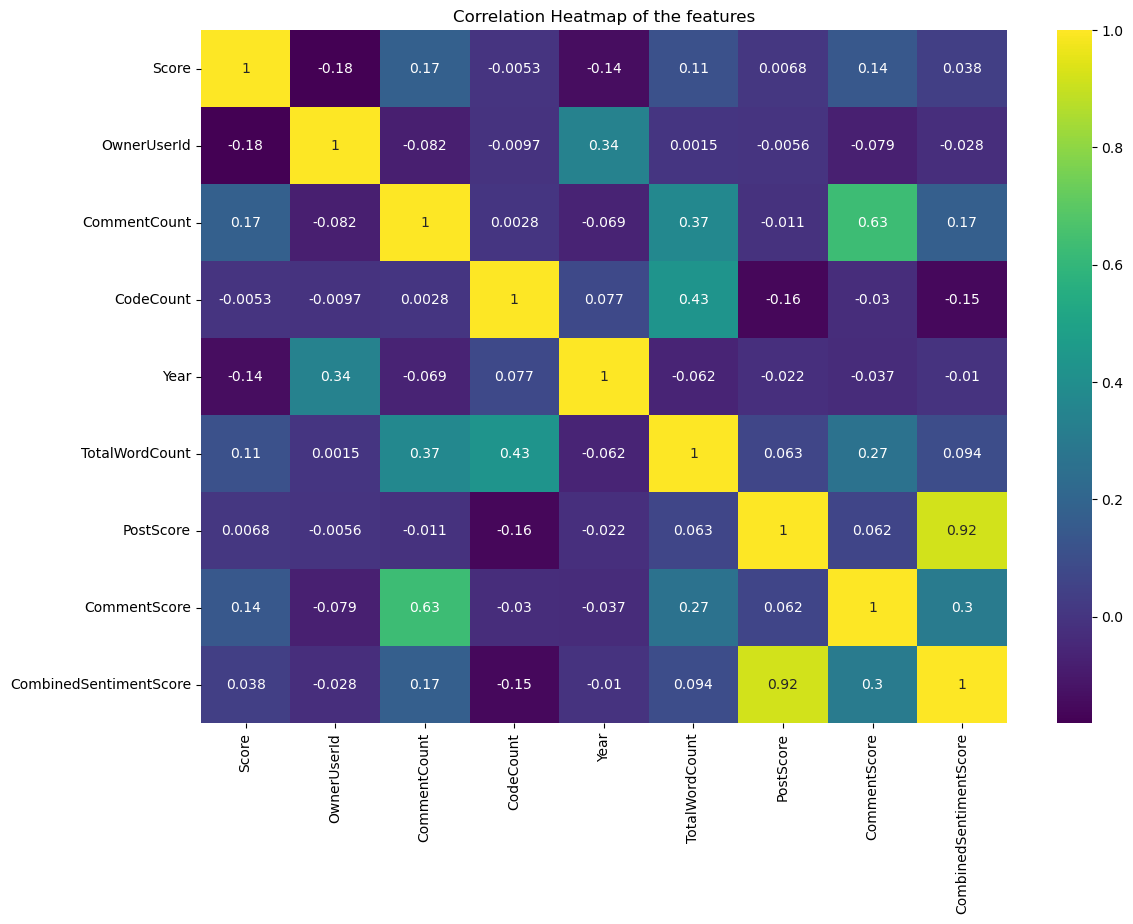

In [57]:
correlation = sentiment_df.drop(columns="TagsList").corr()
plt.figure(figsize=(13,9))
sns.heatmap(correlation,annot=correlation, cmap="viridis")
plt.title("Correlation Heatmap of the features")

Key Observations:
- PostScore and CombinedSentimentScore (0.92): There's a very strong positive correlation between PostScore and CombinedSentimentScore, suggesting that these two features are highly related or that PostScore is a major component of CombinedSentimentScore.
- TotalWordCount with CommentCount (0.37) and CodeCount (0.43): These moderate positive correlations indicate that posts with more words tend to have more comments or code.
- CommentCount with TotalWordCount (0.37): Similarly, higher comment counts are moderately associated with a greater total word count.


### Distribution of numeric features

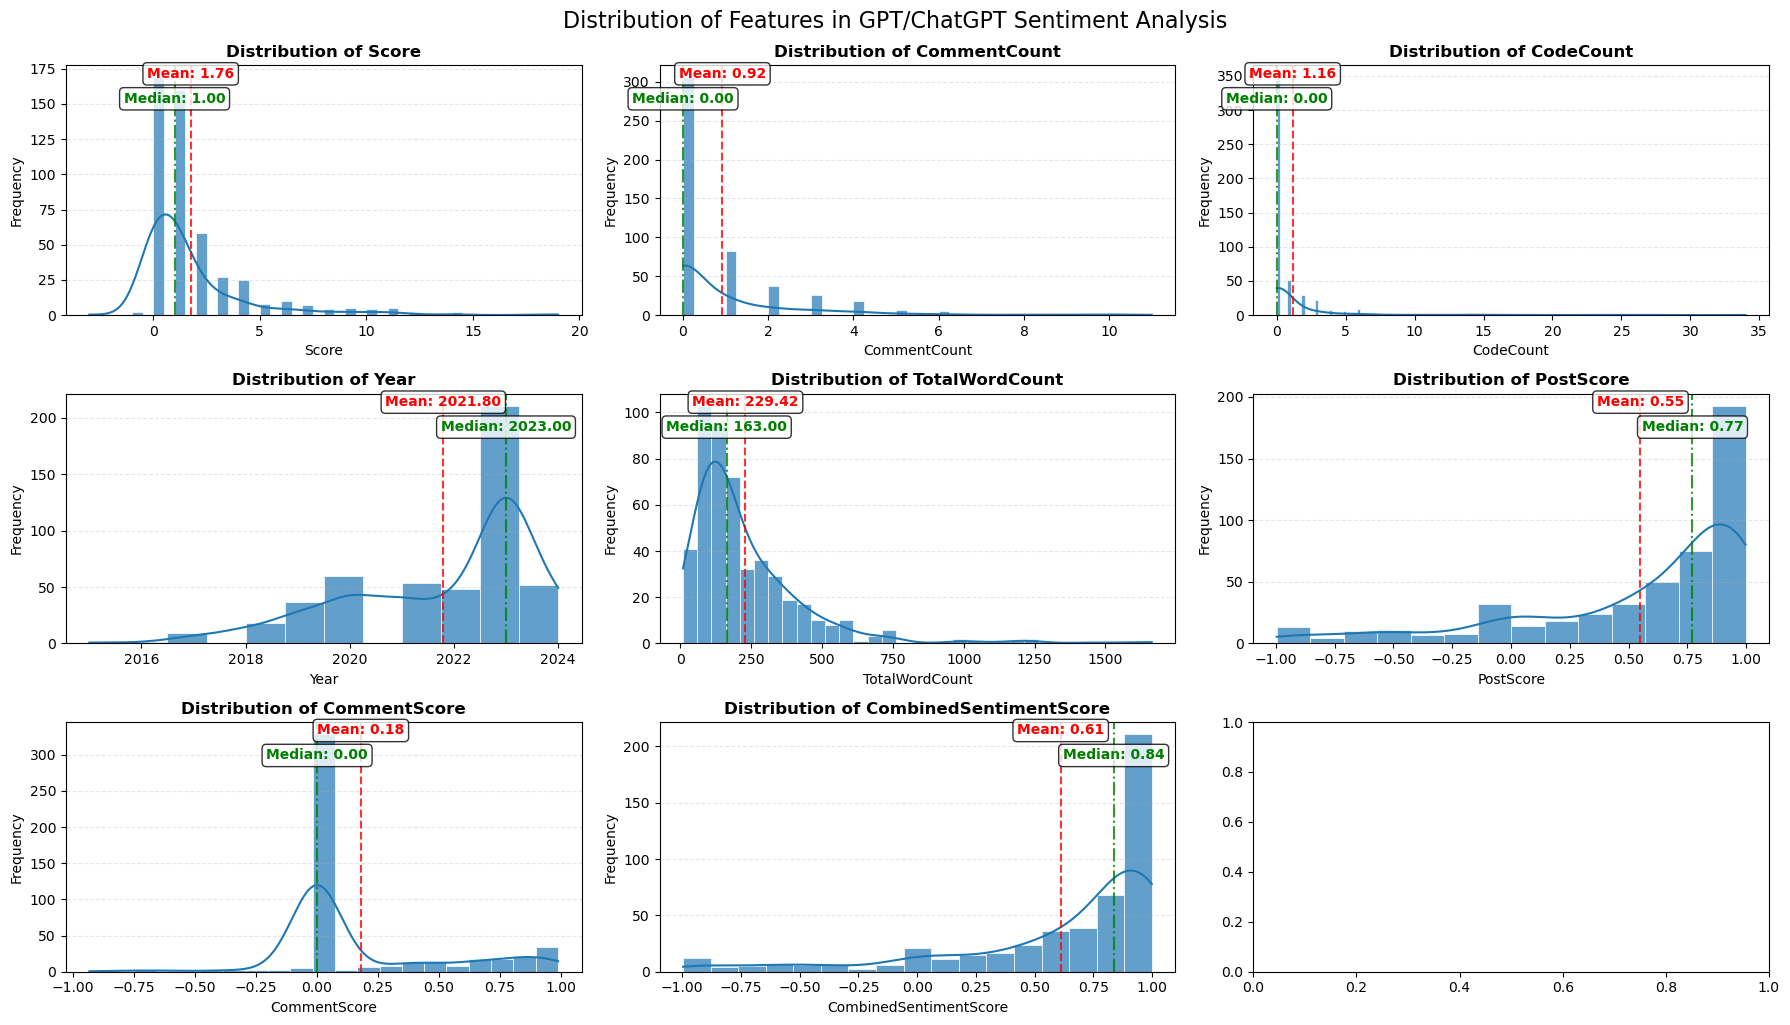

In [58]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(18, 10))
axes = axes.flatten()
for i, col in enumerate(sentiment_df.drop(columns=["TagsList", "OwnerUserId"]).columns):
    sns.histplot(
            data=sentiment_df, 
            x=col, 
            kde=True,
            ax=axes[i],
            alpha=0.7,
            edgecolor='white',
            linewidth=0.5
        )
        
        # Add title and labels
    axes[i].set_title(f'Distribution of {col}', fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    # Add grid for better readability
    axes[i].grid(axis='y', alpha=0.3, linestyle='--')
        
    # Calculate and display mean and median
    mean_val = sentiment_df[col].mean()
    median_val = sentiment_df[col].median()
        
    # Draw vertical lines for mean and median
    axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.8, linewidth=1.5)
    axes[i].axvline(median_val, color='green', linestyle='-.', alpha=0.8, linewidth=1.5)
        
    # Add text annotations for mean and median
    axes[i].text(
            x=mean_val, 
            y=axes[i].get_ylim()[1]*0.95, 
            s=f'Mean: {mean_val:.2f}', 
            color='red',
            fontweight='bold',
            horizontalalignment='center',
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3')
        )
    axes[i].text(
            x=median_val, 
            y=axes[i].get_ylim()[1]*0.85, 
            s=f'Median: {median_val:.2f}', 
            color='green',
            fontweight='bold',
            horizontalalignment='center',
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3')
        )
    #Clear the unsued plot
    if i == 8: 
        axes[i].cla()
        axes[i].axis('off')
plt.tight_layout()
plt.suptitle('Distribution of Features in GPT/ChatGPT Sentiment Analysis', fontsize=16, y=1.02)
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
    

Many features, such as 'Score', 'CommentCount', 'CodeCount', 'TotalWordCount', 'CommentScore', and 'CombinedSentimentScore', exhibit a strong right-skew, with a high frequency of observations concentrated at the lower end of their respective ranges and a long tail extending towards higher values. This skewness is further emphasized by the often significant difference between the mean (red dashed line) and the median (green dashed line), where the mean is pulled to the right by the tail of the distribution. Conversely, the 'Distribution of Year' shows a more uniform or bimodal distribution. Given the prevalence of skewed distributions and the presence of potential outliers in features like 'CommentCount' or 'TotalWordCount', the use of a robust scaler would be highly advantageous. A robust scaler scales features using statistics that are more robust to outliers (like the median and interquartile range) instead of the mean and standard deviation, which are sensitive to extreme values. This approach would help prevent outliers from disproportionately influencing the scaling process, leading to a more normalized and stable feature representation for machine learning models.

**As this is a prediction task with very small number of instances, we will perform a simple linear regression analysis on the dataset to predict the total sentiment score**

### Split the variables into features and target

In [59]:
# Select features and target
X = sentiment_df[['CodeCount', 'Score', 'TotalWordCount', 'CommentCount', 'PostScore', 'CommentScore']]
y = sentiment_df['CombinedSentimentScore']  # Using the continuous sentiment score


### Train-Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with scaling and linear regression
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
# Fit the model
linear_model=LinearRegression()
linear_model.fit(X_train, y_train)

# Transform the test data
X_test = scaler.transform(X_test)
# Make predictions
y_pred = linear_model.predict(X_test)


### Evaluate the models 

Model Performance with Scaled Features:
Mean Squared Error: 0.0214
Root Mean Squared Error: 0.1463
R-squared: 0.9227


/var/folders/dn/pf9_4vwj35g7wrw5hn5rlfn80000gn/T/ipykernel_21598/3663119339.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




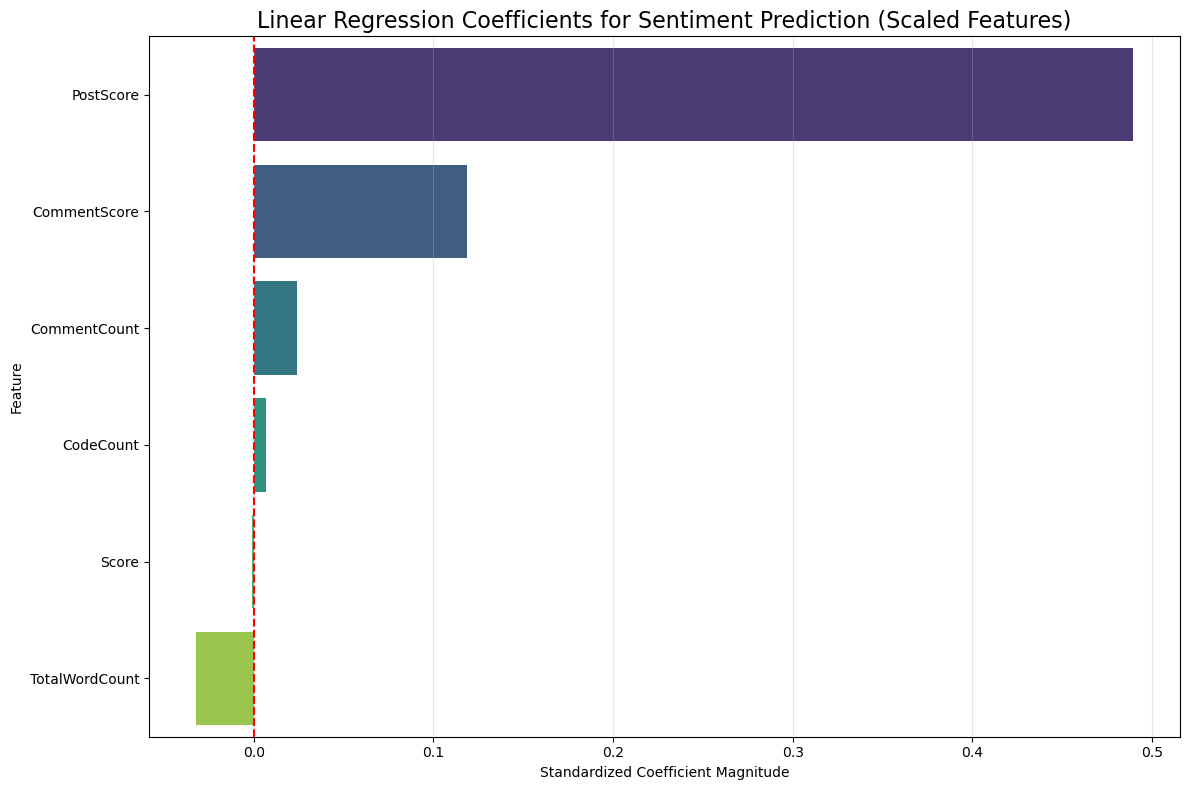

In [104]:

# 8. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 9. Print model performance metrics
print(f"Model Performance with Scaled Features:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

# 10. Get feature coefficients (after scaling)
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': linear_model.coef_
}).sort_values('Coefficient', ascending=False)

# 11. Visualize feature coefficients
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette='viridis')
plt.title('Linear Regression Coefficients for Sentiment Prediction (Scaled Features)', fontsize=16)
plt.xlabel('Standardized Coefficient Magnitude')
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('scaled_sentiment_regression_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

The model's performance metrics indicate a strong fit:
- Mean Squared Error (MSE): 0.0214, which is low, indicating small average squared differences between predicted and actual values.
- Root Mean Squared Error (RMSE): 0.1463, showing the average prediction error in the same units as the target variable.
- R-squared (R²): 0.9227, meaning 92.27% of the variance in the target variable is explained by the model.

This suggests the model is performing well with scaled features. If further improvement is needed, consider exploring feature engineering, hyperparameter tuning, or more complex models.

### Plot the predicted sentiment score against the target

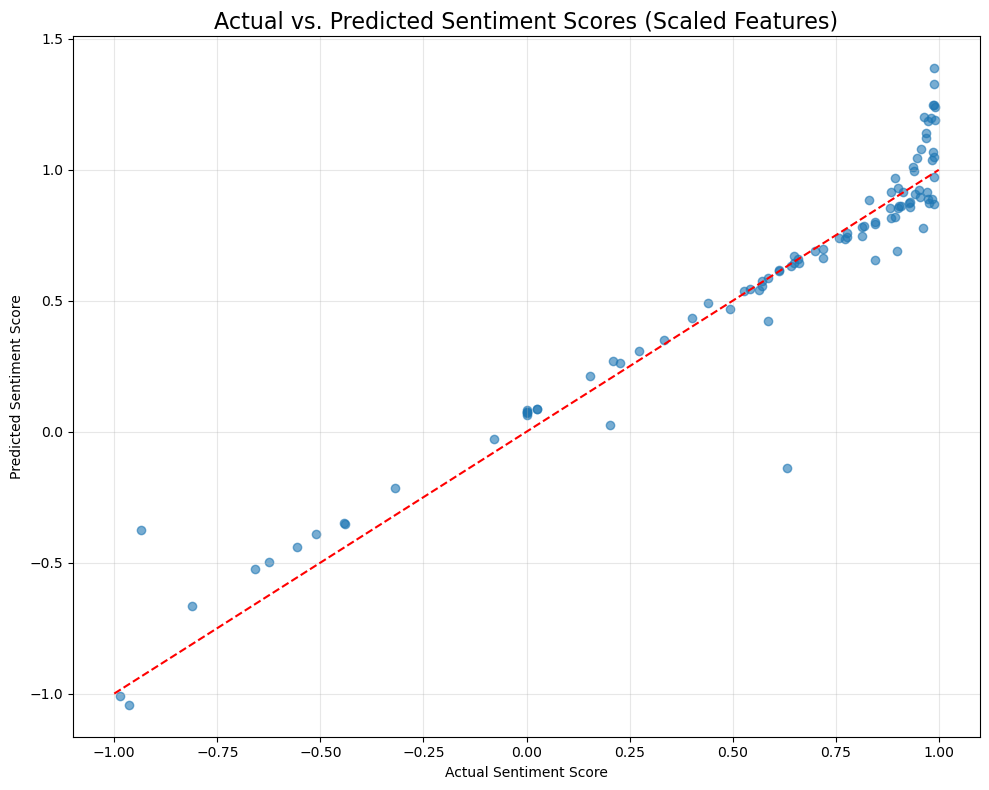

In [103]:

# Visualize actual vs predicted values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([-1, 1], [-1, 1], 'r--')  # Perfect prediction line
plt.xlabel('Actual Sentiment Score')
plt.ylabel('Predicted Sentiment Score')
plt.title('Actual vs. Predicted Sentiment Scores (Scaled Features)', fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('scaled_sentiment_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()


This scatter plot effectively visualizes the performance of a sentiment prediction model by comparing actual scores on the x-axis against predicted scores on the y-axis. The dashed red line represents perfect prediction, and the model generally exhibits a strong positive correlation, with data points clustering well around this line, particularly for actual sentiment scores ranging from neutral to highly positive. This indicates high predictive accuracy in these ranges. While the overall fit is good, there is a noticeable increase in scatter for negative sentiment scores (below approximately -0.25), suggesting slightly less precision in predicting more negative sentiments compared to positive ones. The density of points appears higher at the more positive end of the spectrum, and the use of "Scaled Features" implies standard data preprocessing for improved model performance. Overall, the model demonstrates robust predictive capabilities, though there's a minor area for potential refinement in the prediction of negative sentiments.

## 8. Location Analysis

In this section, we explore the geographical distribution of discussions about ChatGPT by analyzing user-provided location data. By mapping the sentiment and engagement metrics of posts across different regions, we aim to uncover patterns in how ChatGPT is perceived and discussed globally. Using geocoding techniques, we convert location data into coordinates and visualize the results on an interactive map. This analysis provides valuable insights into regional trends, highlighting areas with high engagement and varying sentiment toward ChatGPT.



### Merge the users dataset with the gpt posts 

We will extract the users that created posts on ChatGPT and recalculate the sentiment scores

In [63]:
# Extract location data from users and merge with sentiment data
user_locations = users_df[['Id', 'Location']].dropna(subset=['Location'])
user_locations = user_locations.rename(columns={'Id': 'OwnerUserId'})

# Merge user locations with posts
location_df = pd.merge(
    left=gpt_post_df[['Id','CreationDate', 'OwnerUserId', 'PostText', 'CodeCount', 'Score']],
    right=user_locations,
    on='OwnerUserId',
    how='inner'
)

# Calculate sentiment for each post
location_df['SentimentScore'] = location_df['PostText'].apply(get_sentiment_score)
location_df['Sentiment'] = location_df['SentimentScore'].apply(classify_sentiment)

Quick look at the location dataset

In [64]:
location_df

Id            CreationDate  OwnerUserId  \
0     13820 2016-09-02 11:15:19.617      24007.0   
1     16067 2017-01-04 14:17:56.523        836.0   
2     16072 2017-01-04 17:36:53.577       8820.0   
3     18741 2017-05-04 09:58:04.127       5041.0   
4     20181 2017-07-05 07:16:56.973      33738.0   
..      ...                     ...          ...   
236  128401 2024-03-22 06:59:18.400      14675.0   
237  128438 2024-03-25 15:44:23.787     161771.0   
238  128490 2024-03-29 09:05:09.473     143103.0   
239  128492 2024-03-29 11:55:58.047      76453.0   
240  128493 2024-03-29 12:20:26.163     143103.0   

                                              PostText  CodeCount  Score  \
0    installed orange version yesterday defined var...          1      1   
1    multiple way approach solving game playing pro...          0      8   
2    looking called reinforcement learning universi...          0      4   
3    would recommend look openai gym easier impleme...          0      1   
4    tldr something like feasible know nothing said...          0      2   
..                                                 ...        ...    ...   
236  openai embeddings extracted chatgpt trained in...          0      1   
237  total sa noob dont like far tried different me...          4      0   
238  maybe dont understand functionality web versio...          0      0   
239  want finetune slm like phi2 huggingface api do...          3      0   
240  asked reddit didnt expect answer easy chatgpt ...          0      1   

                       Location  SentimentScore Sentiment  
0       New Delhi, Delhi, India          0.9186  Positive  
1        Durham, United Kingdom          0.9860  Positive  
2          München, Deutschland          0.5267  Positive  
3              Zug, Switzerland          0.3818  Positive  
4                         India          0.9925  Positive  
..                          ...             ...       ...  
236            Barcelona, Spain          0.7269  Positive  
237                     Belgium          0.9844  Positive  
238  Johannesburg, South Africa          0.6866  Positive  
239                      Munich          0.9971  Positive  
240  Johannesburg, South Africa         -0.6377  Negative  

[241 rows x 9 columns]

### Extract the coordinates of the user's location

Based on the locations in the datset, we call the `geopy` function to extract the longitude and latitude of the location.

In [65]:
from geopy.geocoders import Nominatim
# Function to get latitude and longitude for a location
def get_lat_long(location):
    geolocator = Nominatim(user_agent="GeoApi") #Initialize the model
    try:
        location = geolocator.geocode(location)
        print(location)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except Exception as e:
        print(f"Error geocoding location: {e}")
        return None, None
# Apply geocoding to get coordinates (this may take time)
location_df['Coordinates'] = location_df['Location'].apply(
    lambda x: get_lat_long(x) if pd.notnull(x) else (None, None)
)
location_df['Latitude'] = location_df['Coordinates'].apply(lambda x: x[0] if x is not None else None)
location_df['Longitude'] = location_df['Coordinates'].apply(lambda x: x[1] if x is not None else None)

# Filter out rows with no coordinates
geo_df = location_df.dropna(subset=['Latitude', 'Longitude'])

New Delhi, Foot Over Bridge 1, Ram Nagar, New Delhi Railway Station, Delhi, Kotwali Tehsil, Central Delhi, Delhi, 110006, India
County Durham, North East, England, United Kingdom
München, Bayern, Deutschland
Zug, Schweiz/Suisse/Svizzera/Svizra
India
City of New York, New York, United States
City of New York, New York, United States
München, Bayern, Deutschland
City of New York, New York, United States
Berlin, Deutschland
Heidelberg, Baden-Württemberg, Deutschland
Heidelberg, Baden-Württemberg, Deutschland
Heidelberg, Baden-Württemberg, Deutschland
Bern, Verwaltungskreis Bern-Mittelland, Verwaltungsregion Bern-Mittelland, Bern/Berne, Schweiz/Suisse/Svizzera/Svizra
San Francisco, California, United States
County Durham, North East, England, United Kingdom
County Durham, North East, England, United Kingdom
County Durham, North East, England, United Kingdom
Pune City, Pune, Maharashtra, India
City of New York, New York, United States
Hamburg, Deutschland
India
Canada
India
Canada
Barcelona

### Maps of ChatGPT posts user

We create a map of users' locations based on the extracted coordinates and color the pins by sentiments

In [ ]:
# Create a basic map centered at the mean of the coordinates
center_lat = geo_df['Latitude'].mean()
center_lng = geo_df['Longitude'].mean()
map_base = folium.Map(location=[center_lat, center_lng], zoom_start=3)

# Add markers with clustering
marker_cluster = MarkerCluster().add_to(map_base)

# Define color function based on sentiment
def get_color(sentiment):
    if sentiment == 'Positive':
        return 'green'
    elif sentiment == 'Negative':
        return 'red'
    else:
        return 'blue'

# Add each point to the map
for idx, row in geo_df.iterrows():
    popup_text = f"""
    <strong>Location:</strong> {row['Location']}<br>
    <strong>Sentiment:</strong> {row['Sentiment']}<br>
    <strong>Score:</strong> {row['Score']}<br>
    <strong>CodeCount:</strong> {row['CodeCount']}
    """
    
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=folium.Popup(popup_text, max_width=300),
        icon=folium.Icon(color=get_color(row['Sentiment']))
    ).add_to(marker_cluster)

# Save the map
map_base.save('chatgpt_post_locations.html')
display(map_base)

This map shows that the users of this particular thread come from every continent in the world. However, the continent with the highest concentration is Europe. This is followed by Asia with 52 users and North America with 47 users. A closer look into each continent shows that, most of the users post positive discussion about ChatGPT and there are only a small number of negative posts in each continent. 

## 9. Advanced Insights

In this section, we delve deeper into the dataset to uncover advanced insights by leveraging thematic analysis and geospatial visualization. Using AI-powered tools, we extract thematic categories from posts and comments to identify key discussion topics, such as ethical concerns, technical implementations, and privacy issues. Additionally, we analyze the geographical distribution of posts to understand how discussions about ChatGPT vary across different regions. This section aims to provide a comprehensive understanding of the broader context and themes surrounding ChatGPT discussions, offering valuable perspectives on the global and thematic dimensions of the dataset.

### Set up the Ollama API call function

In [ ]:
# Install Ollama
curl -fsSL https://ollama.com/download/ollama-darwin-amd64 -o ollama
chmod +x ollama
sudo mv ollama /usr/local/bin/

# Start Ollama service
ollama serve

# In a new terminal, pull the DeepSeek model
ollama pull deepseek-r1:latest

# Verify installation
ollama list

In [67]:
def query_ollama(prompt, model="deepseek-r1:latest"):
    url = "http://localhost:11434/api/generate"
    payload = {
        "model": model,
        "prompt": prompt,
    }
    response = requests.post(url, json=payload)
    result = ""
    for line in response.text.splitlines():
        data = json.loads(line)
        if "response" in data:
            result += data["response"]
    return result.strip()

### Prepare the prompt for the model

In [68]:
def get_theme(text):
    prompt = f"Summarize the following text in about 7-8 words and assign it to a thematic category (e.g., Ethical concern, Technical Implementation, Privacy Problem, ...). Give your answer in the format: Summary: ... Category: ... . There should be no redundant information and ensure that all text should be summarised. Here is the text: {text}"
    response = query_ollama(prompt)

    return response

### Extract the theme of each post

*This cell could take up to 2 hours to run depending on the computer's hardware*

In [69]:
merged_df["TotalText"] = merged_df["CleanBody"] + " " + merged_df["CleanComment"]
merged_df["Theme"] = merged_df["TotalText"].apply(get_theme)

In [70]:
merged_df["Theme"][1]

'<think>\nOkay, so I have this text where the user installed Orange version 3 and defined some variables in an Excel file following the documentation. When they used simple plots, everything worked fine, but when they tried a classifier, there was an error saying "data has no target variable." They already set and saved the target variables, which is confusing because it should be present.\n\nLooking at their data structure, I see that for each enzyme like \'enzyme type\', there are several columns labeled with years, such as \'2 year exp\', \'4 year exp\', etc. These might represent different measurements over time. Then they have various factors like \'sgot\', \'class\', \'ggt\', and so on, which could be categorical variables.\n\nThe user is getting an error when running a classifier but has the target variable set. Maybe in their data structure, the target variable isn\'t correctly labeled or perhaps there\'s a mismatch between how they defined it in Excel versus what the model exp

### Function to clean the model's response

We create a function to remove redundant information in the model's reponse and then extract the summary and category section.

In [75]:
def extract_theme_components(theme_text):
    """
    Extract the summary and category from the themed text.
    
    Parameters:
        theme_text (str): The theme text to parse
        
    Returns:
        tuple: (summary, category)
    """
    if pd.isna(theme_text) or not isinstance(theme_text, str):
        return ("Unknown", "Uncategorized")
    
    # Remove <think>...</think> parts
    theme_text = re.sub(r'<think>.*?</think>', '', theme_text, flags=re.DOTALL).strip()
    
        
    # Try to extract using the expected format
    try:
        # Look for the pattern "Summary: ... Category: ..."
        if "Summary:" in theme_text and "Category:" in theme_text:
            parts = theme_text.split("Category:")
            summary = parts[0].replace("Summary:", "").strip()
            category = parts[1].strip()
        # Sometimes the format might be different
        elif ":" in theme_text:
            # Try to find the last colon which might separate summary from category
            parts = theme_text.rsplit(":", 1)
            summary = parts[0].strip()
            category = parts[1].strip()
        else:
            # Default fallback
            summary = theme_text
            category = "General"
            
        # Clean and standardize categories
        category = category.strip().title()
        if not category:
            category = "General"
            
        return (summary, category)
    except Exception as e:
        print(f"Error parsing theme: {e}")
        return (theme_text, "Parsing Error")

In [76]:
# Apply the extraction function to the Theme column
merged_df[['Summary', 'Category']] = merged_df['Theme'].apply(
    lambda x: pd.Series(extract_theme_components(x))
)

merged_df['Category'] = merged_df['Category'].apply(clean_text)
# Look at the distribution of categories
category_counts = merged_df['Category'].value_counts()
category_counts

Category
technical implementation              234
ethical concern                        20
reinforcement learning                  4
transformer architecture                3
privacy problem                         3
                                     ... 
dataset generation                      1
statistical modeling                    1
model architecture and differences      1
model enhancement                       1
finetuning and model configuration      1
Name: count, Length: 227, dtype: int64

We find a lot of interesting category from the model's response. The pattern is that most of the discussions is related to technical implementations which reflects the nature of Stack Exchange, a platform designated for developers. However, a noticeable number of discussions concentrates on ethical concern of ChatGPT, which is still a highly debatable issue till the current day.

In [ ]:
merged_df['Summary'][0]

'The text discusses various methods for solving game problems, emphasizing search algorithms and reinforcement learning as effective approaches, highlighting their applications in training agents through rewards. It provides resources and outlines the need for mathematical understanding and prior machine learning knowledge.\n\n The text explores game-solving methods using search algorithms and reinforcement learning (RL), providing resources and emphasizing math and ML prerequisites.'

In [84]:
group = merged_df.groupby("Category")['Summary'].count().sort_values(ascending=False)
print(group)

Category
technical implementation                        234
ethical concern                                  20
reinforcement learning                            4
transformer architecture                          3
privacy problem                                   3
                                               ... 
intelligent search and context understanding      1
knowledge acquisition                             1
knowledge drift                                   1
language implementation                           1
word embedding techniques                         1
Name: Summary, Length: 227, dtype: int64


### Sunburst chart for the categories

In [93]:
import plotly.express as px

# Prepare data for sunburst
sunburst_data = merged_df[['Category', 'Summary']].value_counts().reset_index()
sunburst_data.columns = ['Category', 'Summary', 'Count']

# Create sunburst chart
fig = px.sunburst(
    sunburst_data,
    path=['Category', 'Summary'],
    values='Count',
    title='Category and Summary Hierarchy',
    width=1800,  # Set the width of the chart
    height=1500   # Set the height of the chart
)
# Adjust label orientation for better readability
fig.update_traces(insidetextorientation='horizontal')  # Options: 'radial', 'horizontal', 'auto'

fig.show()

Looking closer at the sumamries in each category, we can see that LLM could perform really well in summarizing a long-context input in a short and concise sentence. Although some of the instances do not strictly follow the rules set in the query, we still get very informative results. One of which is the discussion raised on ethical concern. Users express varying opinions about data privacy, OpenAI's profit maximization strategy and AI alignments with human values which are all worth considering further. 

## 10. Discussion



## Overall Observations from the Analysis

Looking at the graphs and analysis results, several key population-level observations can be made:

1. **Temporal Evolution**: ChatGPT discussions showed minimal activity from 2015-2018, followed by gradual growth in 2018-2019, and a dramatic spike in 2023 coinciding with GPT-3's release. The sharp decline in 2024 suggests a potential shift in discussion focus or platform usage.

2. **Content Characteristics**: Posts tend to be concise (mostly 50-200 words) and technically oriented, with a significant majority containing code blocks, reflecting Stack Exchange's developer-centric nature.

3. **Sentiment Distribution**: There's a strong positive sentiment bias in posts (402 positive vs 62 negative), while comments exhibit more neutrality (326 neutral vs 145 positive), suggesting initial enthusiasm followed by more measured discussion.

4. **Global Distribution**: While users come from all continents, Europe shows the highest concentration, followed by Asia and North America, with predominantly positive sentiment across regions.

5. **Thematic Patterns**: Technical implementation discussions dominate, followed by ethical concerns, reflecting both practical and philosophical considerations about ChatGPT technology.

## 11. Notes on privacy and ethics

### Reflection on Data Privacy and Ethics Issues  

During the data analysis process, several potential data privacy and ethics concerns arise that warrant careful consideration:  

1. **User Anonymity and Privacy**:  
   The dataset includes user-generated content, such as posts, comments, and location data. Even though the data may appear anonymized, there is a risk of re-identification, especially when combining multiple data points (e.g., location and user activity). Ensuring that no personally identifiable information (PII) is exposed is critical to maintaining user privacy.  

2. **Ethical Use of Location Data**:  
   The analysis of user-provided location data introduces ethical concerns. Users may not have explicitly consented to their location being used for geospatial analysis. Additionally, inaccuracies in geocoding could lead to misrepresentation of user locations, potentially causing harm or misinterpretation of results.  

3. **Bias in Data Representation**:  
   The dataset may inherently reflect biases, such as overrepresentation of certain regions, demographics, or viewpoints. This could lead to skewed insights that fail to represent the global or diverse perspectives on ChatGPT. Addressing these biases is essential to ensure fair and balanced analysis.  

4. **Sentiment Misclassification**:  
   Sentiment analysis relies on algorithms that may misinterpret the tone or context of user-generated content. This could lead to incorrect conclusions about user opinions, potentially misrepresenting the sentiment of discussions.  

5. **Ethical Implications of Thematic Analysis**:  
   Thematic analysis involves categorizing user discussions into topics, which may inadvertently oversimplify or misrepresent the complexity of user concerns. Care must be taken to ensure that the themes accurately reflect the content without introducing researcher bias.  

6. **Transparency and Accountability**:  
   It is important to maintain transparency about the methods and tools used in the analysis. Users whose data is being analyzed should ideally be informed about how their data is being used and for what purpose.  

To address these concerns, it is crucial to implement robust data anonymization techniques, ensure compliance with ethical guidelines, and critically evaluate the limitations of the analysis methods. Additionally, researchers should strive to minimize bias, respect user privacy, and maintain accountability throughout the data analysis process.

## Conclusion

The analysis reveals significant trends and patterns in discussions about ChatGPT, including the prevalence of technical topics, sentiment distribution, and regional variations in user engagement. Sentiment analysis highlights a predominantly positive outlook in posts, while comments tend to be more neutral. Thematic analysis uncovers key discussion topics, such as ethical concerns, technical implementations, and privacy issues. Geospatial visualization provides insights into the global distribution of discussions. Throughout the project, ethical considerations were prioritized to ensure responsible data handling. Overall, this study offers a comprehensive understanding of the discourse surrounding ChatGPT, contributing to the broader conversation about AI technologies and their societal impact.

